# Deep Learning Assignement
Group memebers:
- Bando Matteo (ID: 259068)
- Fin Jonathan (ID: 256178)
- Netti Vincenzo (ID: 256245)

## Objective: Few-shot adaptation of CLIP on some classes of Flowers102 dataset
CLIP has impressive zero shot accuracy. The goal of the assignment is to improve its accuracy on given classes (**base**)
but still maintain its zero shot accuracy on the other unseen classes (**novel**)

In [1]:
# Installing and importing the requirements
!pip install openai-clip  # For colab

import torch
import torchvision
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast
from tqdm import tqdm
from typing import Tuple
from typing import List
import os
import clip
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
from tabulate import tabulate
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from IPython.display import Markdown, display

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.4 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368605 sha256=98db3bf0f96f22f64a0989112de28101ffefc8eb2acc4367bb02d0d2567a7acd
  Stored in directory: /root/.cache/pip/wheels/0d/17/90/042948fd2e2a87f1dcf6db6d438cad015c49db0c53d1d9c7dc
Successfully built openai-clip


In [2]:
# Create folder if it doesn't exist (for saving models)
os.makedirs("models", exist_ok=True)

# Seed for reproducibility
SEED = 42

# Function to set random seed for reproducibility
def set_seed(seed):
    """Set random seed for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed for reproducibility
set_seed(SEED)

# Worker init function
def worker_init_fn(worker_id):
    np.random.seed(SEED + worker_id)
    random.seed(SEED + worker_id)

### Utilities for data handling

In [3]:
def get_data(data_dir="../data", transform=None):
    """Load Flowers102 train, validation and test sets.
    Args:
        data_dir (str): Directory where the dataset will be stored.
        transform (torch.Compose)
    Returns:
        tuple: A tuple containing the train, validation, and test sets.
    """
    train = torchvision.datasets.Flowers102(root=data_dir, split="train", download=True, transform=transform)
    val = torchvision.datasets.Flowers102(root=data_dir, split="val", download=True, transform=transform)
    test = torchvision.datasets.Flowers102(root=data_dir, split="test", download=True, transform=transform)
    return train, val, test

def base_novel_categories(dataset):
    """Optimized version for Flowers102 dataset (102 classes)"""
    num_classes = 102
    base_classes = list(range(num_classes))[:num_classes//2]  # 0-50
    novel_classes = list(range(num_classes))[num_classes//2:]  # 51-101
    return base_classes, novel_classes


def get_labels(dataset):
    # If dataset is a Subset, get labels from the underlying dataset
    if isinstance(dataset, torch.utils.data.Subset):
        return [dataset.dataset[i][1] for i in dataset.indices]
    else:
        return [dataset[i][1] for i in range(len(dataset))]


def split_data(dataset, base_classes):
    # These two lists will store the sample indexes
    base_categories_samples = []
    novel_categories_samples = []

    # We create a set of base classes to compute the test below in O(1)
    # This is optional and can be removed
    base_set = set(base_classes)
    labels = get_labels(dataset)
    # Here we iterate over sample labels and also get the correspondent sample index
    for sample_id, label in enumerate(labels):
        if label in base_set:
            base_categories_samples.append(sample_id)
        else:
            novel_categories_samples.append(sample_id)

    # Here we create the dataset subsets
    # the torch Subset is just a wrapper around the dataset
    # it simply stores the subset indexes and the original dataset (your_subset.dataset)
    # when asking for sample i in the subset, torch will look for its original position in the dataset and retrieve it
    # https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset
    base_dataset = torch.utils.data.Subset(dataset, base_categories_samples)
    novel_dataset = torch.utils.data.Subset(dataset, novel_categories_samples)
    return base_dataset, novel_dataset

def harmonic_mean(base_accuracy, novel_accuracy):
    numerator = 2
    denominator = 1 / base_accuracy + 1 / novel_accuracy
    hm = numerator / denominator
    return hm


In [4]:
# Model and data
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/16", device=DEVICE)
_, _, tmp_test = get_data()
base_classes, novel_classes = base_novel_categories(tmp_test)
CLASS_NAMES = ["pink primrose", "hard-leaved pocket orchid", "canterbury bells", "sweet pea", "english marigold", "tiger lily", "moon orchid", "bird of paradise", "monkshood", "globe thistle", "snapdragon", "colt's foot", "king protea", "spear thistle", "yellow iris", "globe-flower", "purple coneflower", "peruvian lily", "balloon flower", "giant white arum lily", "fire lily", "pincushion flower", "fritillary", "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers", "stemless gentian", "artichoke", "sweet william", "carnation", "garden phlox", "love in the mist", "mexican aster", "alpine sea holly", "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip", "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia", "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy", "common dandelion", "petunia", "wild pansy", "primula", "sunflower", "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia", "pink-yellow dahlia?", "cautleya spicata", "japanese anemone", "black-eyed susan", "silverbush", "californian poppy", "osteospermum", "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania", "azalea", "water lily", "rose", "thorn apple", "morning glory", "passion flower", "lotus", "toad lily", "anthurium", "frangipani", "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow", "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum", "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow", "mexican petunia", "bromelia", "blanket flower", "trumpet creeper", "blackberry lily"]
train_set, val_set, test_set = get_data(transform=preprocess)
base_classes, novel_classes = base_novel_categories(train_set)

train_base, _ = split_data(train_set, base_classes)
val_base, _ = split_data(val_set, base_classes)
test_base, test_novel = split_data(test_set, base_classes)

100%|███████████████████████████████████████| 335M/335M [00:12<00:00, 27.1MiB/s]
100%|██████████| 345M/345M [00:11<00:00, 30.1MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.01MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 32.9MB/s]


### Baseline accuracy computation

In [5]:
@torch.no_grad()
def eval(model, dataset, categories, batch_size, device, label=""):
    model.eval()
    # Remap labels into a contiguous set starting from zero
    contig_cat2idx = {cat: idx for idx, cat in enumerate(categories)}
    # Apply and tokenize standard clip sentences
    text_inputs = clip.tokenize(
        [f"a photo of a {CLASS_NAMES[c]}, a type of flower." for c in categories]
    ).to(device)

    # We encode the text features once as they are shared for all images
    text_features = model.encode_text(text_inputs)
    # Normalization, standard clip practice
    text_features /= text_features.norm(dim=-1, keepdim=True)

    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        worker_init_fn=worker_init_fn)

    correct_predictions = 0
    for image, target in tqdm(dataloader, desc=label):
        # Label remapping
        target = torch.Tensor([contig_cat2idx[t.item()] for t in target]).long()

        image = image.to(device)
        target = target.to(device)

        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # Cosine similarity between image and text features and keep the argmax for every image
        predicted_class = (image_features @ text_features.T).argmax(dim=-1)

        correct_predictions += (predicted_class == target).sum().item()

    # And now we compute the accuracy
    accuracy = correct_predictions / len(dataset)
    return accuracy

zero_shot_base_accuracy = eval(model=model, dataset=test_base, categories=base_classes, batch_size=128, device=DEVICE, label="🧠 Zero-shot evaluation on Base Classes")
zero_shot_novel_accuracy = eval(model=model, dataset=test_novel, categories=novel_classes, batch_size=128, device=DEVICE, label="🧠 Zero-shot evaluation on Novel Classes")

print()
print(f"🔍 Base classes accuracy: {zero_shot_base_accuracy*100:.2f}%")
print(f"🔍 Novel classes accuracy: {zero_shot_novel_accuracy*100:.2f}%")


🧠 Zero-shot evaluation on Novel Classes: 100%|██████████| 29/29 [00:14<00:00,  2.05it/s]


🔍 Base classes accuracy: 71.33%
🔍 Novel classes accuracy: 78.26%


## Our Approach

Most few-shot methods achieve higher accuracy w.r.t. CLIP on the base classes but they loose generalization on the novel one.
Our intuition is that those approaches and standard zero shot clip should be balanced when predicting the final output.
To determine which weights to assign to the few-shot method and clip we decided prototypes and similarity, the more a sample is similar to one fo the prototypes of the base classes the more likely it belongs to our base set and thus higher weight should be assigned to the few-shot method, vice versa if it belongs to the novel set.  

---

## Table of Contents

1. [**TIP-Adapter: Description and implementation**](#1-tip-adapter)
2. [**Prototype Cache: Similarity-Based Weighting Strategy**](#2-prototype-cache-similarity-based-weighting-strategy)
3. [**Dynamic CoOp**](#3-dynamic-coop)
4. [**Dynamic CoCoOp**](#4-dynamic-cocoop)
5. [**Conclusions**](#5-conclusions)
6. [**Other work**](#6-other-work---apollo)
7. [**References**](#7-references)


---

# 1. TIP-Adapter
Tip-Adapter is a training-free extension of CLIP that builds a cache made using the few-shot samples, the cache is then processed using non linear operations and then combined with clip before computing the standard output.

## How the Cache is Computed and Combined with CLIP:
For each training image:

1. Keys: extract CLIP visual features $(F_{train})$ using the frozen visual encoder. its shape is $(N*K,C)$ where  $N$ is the total number of classes, $K$ is the number of shots and $C$ is the dimension of the visual embedding
   
2. Values: Convert labels to one-hot vectors $(L_{train})$. its shape is $(N*K,N)$

The two MLP layers in the adapter are set as:

1. $W_1 = F_{train}$

1. $W_2 = L_{train}$

**Activation**: $ϕ(x) = \exp(−β(1 − x))$

**Tip adpter logits**: $Logits_{tipadapter} = ϕ(f_{test} · W_1^T) · W_2 $, where $f_{test}$ are the visual features of the current image

**Final logits**: $\alpha * Logits_{tipadapter} + Logits_{clip}$



In [6]:
# Building the cache
@torch.no_grad()
def create_cache(model: torch.nn.Module, base_dataset: torch.utils.data.Subset, device: str,cache_path='tip_adapter_cache.pt') -> Tuple[Tensor,Tensor]:

    if os.path.exists(cache_path):
        # Loading the cache in case it already exists
        print("Loading cache")
        cache = torch.load(cache_path,map_location=torch.device('cpu'))
        keys = cache['keys']
        vals = cache['vals']
        return keys,vals

    model.eval()
    keys = []
    vals = []
    dataloader = torch.utils.data.DataLoader(
        base_dataset,
        batch_size=128,
        shuffle=False,
        num_workers=2,
        worker_init_fn=worker_init_fn)

    for img,target in tqdm(dataloader, desc="Encoding few-shot images"):
        img = img.to(device)
        target = target.to(device)
        # Computing the visual embeddings
        features: Tensor = model.encode_image(img)
        keys.append(features)
        vals.append(target)

    keys = torch.cat(keys, dim=0)
    keys /= keys.norm(dim=-1,keepdim=True)
    vals = torch.cat(vals, dim=0)
    vals = F.one_hot(vals).half()
    # Saving the cache, commented for the colab notebook
    # torch.save({'keys': keys, 'vals': vals}, 'models/tip_adapter_cache.pt')

    return keys, vals

### Tip-adapter Evaluation

In [7]:
@torch.no_grad()
def eval_tipAdapt(model, dataset, categories, batch_size, device, label="",keys = None,values = None,alpha = 0.1):
    assert keys is not None and values is not None, "Keys and values must be provided"
    model.eval()
    keys   = keys.to(device)
    values = values.to(device)

    contig_cat2idx = {cat: idx for idx, cat in enumerate(categories)}
    text_inputs = clip.tokenize(
        [f"a photo of a {CLASS_NAMES[c]}, a type of flower." for c in categories]
    ).to(device)

    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        worker_init_fn=worker_init_fn)

    correct_predictions = 0
    for image, target in tqdm(dataloader, desc=label):

        target = torch.Tensor([contig_cat2idx[t.item()] for t in target]).long()

        image = image.to(device)
        target = target.to(device)

        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        beta = 5.5  # value choosen according to the tip adapter's paper
        # Using autocast to avoid float precision errors
        with autocast(device):
            A = torch.exp(-beta * (1-(image_features @ keys.T)))
            # Combining tip logits and clip logits
            logits = alpha * (A@values) + (image_features @ text_features.T)
        predicted_class = (logits).argmax(dim=-1)
        correct_predictions += (predicted_class == target).sum().item()

    accuracy = correct_predictions / len(dataset)
    return accuracy

In [8]:
# Testing different values of alpha
keys,values = create_cache(model,train_base,DEVICE)
tip_adapter_results = []

# Save last result for final table
tip_final_base_acc = 0
tip_final_novel_acc = 0

alphas = [0.01, 0.5, 1]
for alpha in alphas:
    base_acc = eval_tipAdapt(model=model, dataset=test_base, categories=base_classes, batch_size=128, device=DEVICE, label="🧠 Tip adapter evaluation on Base Classes",keys=keys,values=values,alpha=alpha)
    novel_acc = eval_tipAdapt(model=model, dataset=test_novel, categories=novel_classes, batch_size=128, device=DEVICE, label="🧠 Tip adapter evaluation on Novel Classes",keys=keys,values=values,alpha=alpha)
    hmean = harmonic_mean(base_acc, novel_acc)
    tip_adapter_results.append([
        f"{alpha:.2f}",
        f"{base_acc * 100:.2f}%",
        f"{novel_acc * 100:.2f}%",
        f"{hmean * 100:.2f}%"
    ])

    tip_final_base_acc = base_acc
    tip_final_novel_acc = novel_acc

headers = ["α (Alpha)", "🎯 Base Accuracy", "🧪 Novel Accuracy", "⚖️ Harmonic Mean"]
print(tabulate(tip_adapter_results, headers=headers, tablefmt="alpaha impact on accuracy"))

🧠 Tip adapter evaluation on Novel Classes: 100%|██████████| 29/29 [00:14<00:00,  2.03it/s]

  α (Alpha)  🎯 Base Accuracy    🧪 Novel Accuracy    ⚖️ Harmonic Mean
-----------  ------------------  -------------------  ------------------
       0.01  81.60%              75.14%               78.24%
       0.5   91.10%              2.83%                5.49%
       1     90.86%              2.18%                4.25%


We observe that α (alpha) significantly influences the harmonic mean performance, as it controls the weight assigned to the Tip-Adapter predictions. A larger α increases the reliance on the Tip-Adapter, which typically improves accuracy on base classes but reduces accuracy on novel classes due to overfitting to the base distribution. Conversely, when α = 0, the adapter contributes nothing, and the model behaves identically to standard CLIP, relying solely on its zero-shot generalization capabilities.
***How can we set alpha without knowning if we are dealing with base or novel classes in advance?***


---

# 2. Prototype Cache: Similarity-Based Weighting Strategy

## Cache Construction: Average Embedding Approach

Our proposed prototype cache fundamentally reimagines the traditional TIP-Adapter cache structure. Instead of storing individual image features as keys, we construct **class prototypes by computing mean embeddings** of all training samples within each base class:

$Prototype_c = \frac{1}{N_c} \cdot Σ_{i=1}^{N_c} f(x_i^c)$


Where:
- $Prototype_c$ represents the prototype for class c
- $N_c$ is the number of training samples in class c  
- $f(x_i^c)$ denotes the CLIP image feature for sample i in class c

This approach offers several advantages:
1. **Reduced Memory Footprint**: Storing one prototype per class instead of all individual features
2. **Noise Reduction**: Averaging mitigates the impact of outlier samples
3. **Stable Representations**: Prototypes provide robust class centroids less susceptible to individual sample variations

## Motivation: Adaptive Weighting Through Similarity

The core innovation lies in using prototype similarities to adaptively weight the combination of TIP-Adapter and CLIP predictions. The underlying hypothesis is that **similarity to base class prototypes serves as a reliable indicator of whether a query belongs to the base or novel class distribution**.

For each query image, we compute its maximum similarity to all base class prototypes using cosine similarity

## Weighting Strategy: Dynamic Alpha Computation

The final prediction combines TIP-Adapter and CLIP outputs through an adaptive weighting scheme:

```
Final_Score = α × TIP_Adapter_Score + CLIP_Score
```
Where α is computed based on the similarity score:

#### Step 1: Similarity Computation
For a query image with features $f_I(x)$, compute similarity to prototype cache $\mathcal{K}$:

$$S = \frac{f_I(x) \cdot \mathcal{K}^T}{\|f_I(x)\| \|\mathcal{K}\|}$$

where $\mathcal{K} \in \mathbb{R}^{N \times D}$ contains $N$ prototype vectors of dimension $D=512$.

#### Step 2: Power Transformation
Apply power transformation to create sharper confidence decisions:

$$\alpha = S^p$$

where $p$ controls the sharpness:
- $p > 1$: pushes high similarities toward 1 and low ones toward 0 (clearer confidence)

The ideal behavior targets:
- **α → 1.0** when similairty is high (query likely from base classes)
- **α → 0.0** when similarity is low (query likely from novel classes)

In [9]:
# Prototype cache construction
@torch.no_grad()
def create_prototype_cache(model: torch.nn.Module, base_dataset: torch.utils.data.Subset, device: str,cache_path='models/prototype_cache.pt') -> Tuple[Tensor,Tensor]:
    if os.path.exists(cache_path):
        print("Loading cache")
        cache = torch.load(cache_path,map_location=torch.device(device))
        keys = cache['keys']
        vals = cache['vals'].half()
        return keys,vals

    model.eval()
    keys = []
    vals = []
    dataloader = torch.utils.data.DataLoader(
        base_dataset,
        batch_size=128,
        shuffle=False,
        num_workers=2,
        worker_init_fn=worker_init_fn)

    for img,target in tqdm(dataloader, desc="Encoding few-shot images"):
        img = img.to(device)
        target = target.to(device)
        features: Tensor = model.encode_image(img)
        keys.append(features)
        vals.append(target)
    keys = torch.cat(keys, dim=0)
    keys /= keys.norm(dim=-1,keepdim=True)
    vals = torch.cat(vals, dim=0)
    unique_labels = torch.unique(vals)
    prototypes = []
    prototype_lable = []

    for label in tqdm(unique_labels, desc='Computing prototypes'):
        class_featues = keys[vals == label]
        proto = torch.mean(class_featues,dim=0)
        proto /= proto.norm(dim=-1,keepdim=True)
        prototypes.append(proto)
        prototype_lable.append(label)
    prototypes_tensor = torch.stack(prototypes, dim=0)
    prototype_labels_tensor = torch.stack(prototype_lable, dim=0)


    num_base_classes = len(unique_labels)
    prototype_labels_one_hot = F.one_hot(prototype_labels_tensor, num_classes=num_base_classes).float()

    # torch.save({'keys': prototypes_tensor, 'vals': prototype_labels_one_hot}, cache_path)

    return prototypes_tensor, prototype_labels_one_hot

In [10]:
# Evaluation
@torch.no_grad()
def eval_prototype_tipAdapt(model, dataset, categories, batch_size, device, label="",keys = None,values = None,beta=15,p=20):
    assert keys is not None and values is not None, "Keys and values must be provided"
    model.eval()

    # Remap labels into a contiguous set starting from zero
    contig_cat2idx = {cat: idx for idx, cat in enumerate(categories)}
    # Using a generic prompt (the default one)
    generic_prompts = [f"a photo of a {CLASS_NAMES[c]}, a type of flower." for c in categories]
    generic_tokens = clip.tokenize(generic_prompts).to(device)
    generic_embeddings = model.encode_text(generic_tokens)

    # Normalize
    generic_embeddings = generic_embeddings / generic_embeddings.norm(dim=-1, keepdim=True)

    text_features = generic_embeddings

    # Simple dataloader creation
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        worker_init_fn=worker_init_fn)

    # Here we store the number of correct predictions we will make
    correct_predictions = 0

    for image, target in tqdm(dataloader, desc=label):
        target = torch.Tensor([contig_cat2idx[t.item()] for t in target]).long()
        image = image.to(device)
        target = target.to(device)
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        with autocast(device):
            S = image_features @ keys.T # Cosine similarity
            S_trans = torch.pow(S,p)    # Lowering the impact fo the similarity
            A = torch.exp(-beta * (1-(S)))
            alpha = S_trans

            # Combinig the score
            logits = alpha * (A@values) + (image_features @ text_features.T)
        predicted_class = (logits).argmax(dim=-1)
        correct_predictions += (predicted_class == target).sum().item()

    # And now we compute the accuracy
    accuracy = correct_predictions / len(dataset)
    return accuracy

The role fo the p and beta parameters:
- **p**:
    Controls the influence of outliers.
    When doing S_trans = torch.pow(S, p), the goal is to make outliers receive small to zero weight.

- **$\beta$ (Sharpness Ratio)** :
    used in torch.exp(-$\beta$ * (1-S)), controls the sharpness of the affinities, when $\beta$ is large only the nearby training samples to the test image have large influences to its class prediction and vice versa.

The parameters $\beta$ and $p$ have great impact on classification accuracy end were choosen using grid search with cross-validation.
In detail, we took the 51 classes from the training set, shuffled their indices and for k times we evaluated the performance on a random spilit of 25 to simulate the base and 25 classes to simulate the novel classes, yes one was left out.
This was done to simulate the original problem settings.

In [11]:
# GRID search cell, if you want to run the full search just in comment the candidates for beta and p
@torch.no_grad()
def create_prototype_cache_crossval_mapped(model: torch.nn.Module,
                                          base_dataset: torch.utils.data.Subset,
                                          base_categories: List[int],
                                          all_categories: List[int],
                                          device: str,
                                          cache_path: str = 'models/prototype_cache.pt',
                                          new: bool = False) -> Tuple[Tensor, Tensor, dict]:
    """
    Create prototype cache for cross validation with consistent dimensions
    Args:
        model: The model to use for encoding
        base_dataset: Dataset subset for base categories
        base_categories: List of base category indices used in this split (e.g., [4,10,21,1,2])
        device: Device to run on
        cache_path: Path to save/load cache
        new: Whether to create new cache or load existing

    Returns:
        Tuple of (prototypes_tensor, prototype_labels_one_hot, mapping)
        - prototypes_tensor: [num_base_categories, feature_dim] - only base category prototypes
        - prototype_labels_one_hot: [num_base_categories, len(base_categories)] - consistent one-hot
        - mapping: dict mapping from base_category to prototype index
    """
    if os.path.exists(cache_path) and not new:
        print("Loading cache")
        cache = torch.load(cache_path, map_location=torch.device(device))
        keys = cache['keys']
        vals = cache['vals'].half()
        mapping = cache.get('mapping', {})
        return keys, vals, mapping

    model.eval()
    keys = []
    vals = []

    dataloader = torch.utils.data.DataLoader(
        base_dataset,
        batch_size=128,
        shuffle=False,
        num_workers=2,
        worker_init_fn=worker_init_fn)

    for img, target in tqdm(dataloader, desc="Encoding few-shot images"):
        img = img.to(device)
        target = target.to(device)
        features: Tensor = model.encode_image(img)
        keys.append(features)
        vals.append(target)

    keys = torch.cat(keys, dim=0)
    keys /= keys.norm(dim=-1, keepdim=True)
    vals = torch.cat(vals, dim=0)

    unique_labels = torch.unique(vals)
    prototypes = []

    # Create mapping from base category to prototype index
    label_to_prototype_idx = {}

    for idx, label in enumerate(tqdm(unique_labels, desc='Computing prototypes')):
        class_features = keys[vals == label]
        proto = torch.mean(class_features, dim=0)
        proto /= proto.norm(dim=-1, keepdim=True)
        prototypes.append(proto)
        label_to_prototype_idx[label.item()] = idx

    prototypes_tensor = torch.stack(prototypes, dim=0)

    prototype_labels_one_hot = torch.eye(len(base_categories), device=device).float()
    # Commented for google colab
    #torch.save({
    #    'keys': prototypes_tensor,
    #    'vals': prototype_labels_one_hot,
    #    'mapping': label_to_prototype_idx,
    #    'base_categories': base_categories,
    #    'all_categories': all_categories
    #}, cache_path)

    return prototypes_tensor, prototype_labels_one_hot, label_to_prototype_idx

def find_best_params_cross_validation(model, train_set, validation_set, categories, batch_size, device, k=5, random_state=SEED):
    """
    Find best hyperparameters using classwise cross validation

    Args:
        model: The model to evaluate
        train_set: Training dataset
        validation_set: Validation dataset
        categories: List of all categories
        batch_size: Batch size for evaluation
        device: Device to run on
        k: Number of splits for cross validation
        random_state: Random seed for reproducibility

    Returns:
        tuple: (best_p, best_beta, cv_results)
    """
    n = len(categories)

    # Hyperparameter candidates based on the heatmap
    #candidates_beta = [15, 20, 30, 35, 40, 50, 60, 80, 90]
    #candidates_p = [15, 20, 30, 40, 50, 90, 120, 150]

    candidates_beta = [30]
    candidates_p = [40]
    # Initialize results structure: {(beta, p): [split_results]}
    param_results = {(beta, p): [] for beta in candidates_beta for p in candidates_p}

    print(f"Starting cross validation...")

    for split_idx in range(k):
        print(f"  Split {split_idx + 1}/{k}")

        # Create random base/novel splits on training data
        random.seed(random_state + split_idx)
        all_categories_shuffled = categories.copy()
        random.shuffle(all_categories_shuffled)

        # Split into 25 base, 25 novel, exclude 1 for compatibility
        base_categories = all_categories_shuffled[:25]
        novel_categories = all_categories_shuffled[25:50]

        # Split datasets based on these categories
        base_set, _ = split_data(validation_set, base_categories)
        novel_set, _ = split_data(validation_set, novel_categories)
        base_setCache, _ = split_data(train_set, base_categories)

        # Create prototype cache for this split
        keys, values, _ = create_prototype_cache_crossval_mapped(
            model=model,
            base_dataset=base_setCache,
            base_categories=base_categories,
            all_categories=categories,
            device=device,
            cache_path=f'models/prototype_tuning_split_{split_idx}.pt',
            new=True
        )

        # Middle loop: iterate through beta values
        for beta in candidates_beta:
            print(f"    Testing beta={beta}")

            # Inner loop: iterate through p values
            for p in candidates_p:
                print(f"      Testing p={p}")

                # Evaluate on base categories (25 categories)
                acc_base = eval_prototype_tipAdapt(
                    model, base_set, base_categories, batch_size, device,
                    label=f"Split {split_idx+1} base - beta={beta}, p={p}",
                    keys=keys, values=values, beta=beta, p=p
                )

                # Evaluate on novel categories (25 categories)
                acc_novel = eval_prototype_tipAdapt(
                    model, novel_set, novel_categories, batch_size, device,
                    label=f"Split {split_idx+1} novel - beta={beta}, p={p}",
                    keys=keys, values=values, beta=beta, p=p
                )

                # Calculate harmonic mean
                hm_acc = harmonic_mean(acc_base, acc_novel)

                param_results[(beta, p)].append({
                    'Split': split_idx + 1,
                    'acc_base': acc_base,
                    'acc_novel': acc_novel,
                    'harmonic': hm_acc
                })

    # Convert results to the original format and calculate statistics
    final_param_results = []

    for beta in candidates_beta:
        for p in candidates_p:
            split_results = param_results[(beta, p)]

            # Calculate mean and std across splits
            mean_acc_base = np.mean([r['acc_base'] for r in split_results])
            mean_acc_novel = np.mean([r['acc_novel'] for r in split_results])
            mean_harmonic = np.mean([r['harmonic'] for r in split_results])

            std_acc_base = np.std([r['acc_base'] for r in split_results])
            std_acc_novel = np.std([r['acc_novel'] for r in split_results])
            std_harmonic = np.std([r['harmonic'] for r in split_results])

            final_param_results.append({
                'beta': beta,
                'p': p,
                'mean_acc_base': mean_acc_base,
                'mean_acc_novel': mean_acc_novel,
                'mean_harmonic': mean_harmonic,
                'std_acc_base': std_acc_base,
                'std_acc_novel': std_acc_novel,
                'std_harmonic': std_harmonic,
                'split_results': split_results
            })

            print(f"beta={beta}, p={p}: Mean harmonic accuracy: {mean_harmonic:.4f} ± {std_harmonic:.4f}")

    # Find best parameters based on mean harmonic accuracy
    best_result = max(final_param_results, key=lambda x: x['mean_harmonic'])
    best_p = best_result['p']
    best_beta = best_result['beta']

    print(f"\nBest parameters: beta={best_beta}, p={best_p}")
    print(f"Best mean harmonic accuracy: {best_result['mean_harmonic']:.4f} ± {best_result['std_harmonic']:.4f}")

    return best_p, best_beta, final_param_results

### Results
In the end we choose beta = 30 and p = 40 even though they were not the best parameters but slightly lower (0.7351) instead of (0.7690)
Since those requires much higher values of beta and p and when that happens the value of alpha which weights the impact of the tip adapter tends toward 0 and therefore resorts to standard clip.
We attribute this behaviour in which standard clip scoore is higher than the weighted tip adapter due to the small dimension mof the validation set.

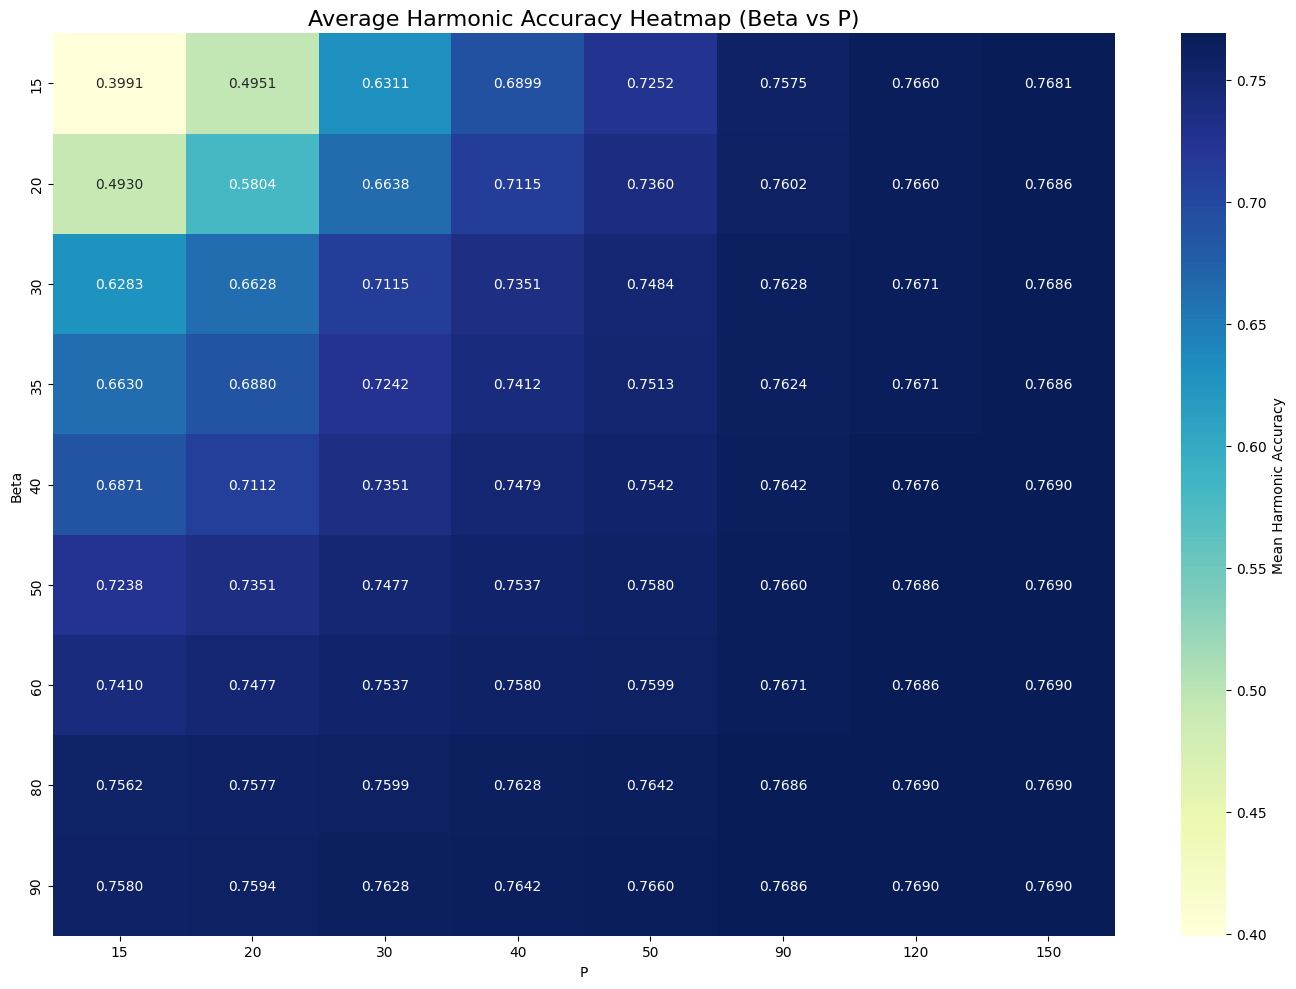

In [12]:
# This cell is used to plot the results obtained with the previous cross validation

# Raw data as string
data_str = """
Beta,P,Harmonic
40,150,0.7690
50,150,0.7690
60,150,0.7690
80,120,0.7690
80,150,0.7690
90,120,0.7690
90,150,0.7690
20,150,0.7686
30,150,0.7686
35,150,0.7686
50,120,0.7686
60,120,0.7686
80,90,0.7686
90,90,0.7686
15,150,0.7681
40,120,0.7676
30,120,0.7671
35,120,0.7671
60,90,0.7671
15,120,0.7660
20,120,0.7660
50,90,0.7660
90,50,0.7660
40,90,0.7642
80,50,0.7642
90,40,0.7642
30,90,0.7628
80,40,0.7628
90,30,0.7628
35,90,0.7624
20,90,0.7602
60,50,0.7599
80,30,0.7599
90,20,0.7594
50,50,0.7580
60,40,0.7580
90,15,0.7580
80,20,0.7577
15,90,0.7575
80,15,0.7562
40,50,0.7542
50,40,0.7537
60,30,0.7537
35,50,0.7513
30,50,0.7484
40,40,0.7479
50,30,0.7477
60,20,0.7477
35,40,0.7412
60,15,0.7410
20,50,0.7360
30,40,0.7351
40,30,0.7351
50,20,0.7351
15,50,0.7252
35,30,0.7242
50,15,0.7238
30,30,0.7115
20,40,0.7115
40,20,0.7112
15,40,0.6899
35,20,0.6880
40,15,0.6871
20,30,0.6638
35,15,0.6630
30,20,0.6628
15,30,0.6311
30,15,0.6283
20,20,0.5804
15,20,0.4951
20,15,0.4930
15,15,0.3991
"""

# Read into DataFrame
df = pd.read_csv(StringIO(data_str))

# Pivot the table for heatmap
pivot_table = df.pivot(index="Beta", columns="P", values="Harmonic")
# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="YlGnBu", cbar_kws={'label': 'Mean Harmonic Accuracy'})
plt.title("Average Harmonic Accuracy Heatmap (Beta vs P)", fontsize=16)
plt.xlabel("P")
plt.ylabel("Beta")
plt.tight_layout()
plt.show()


In [13]:
# Evaluation
keys,values = create_prototype_cache(model,train_base,DEVICE)
beta,p,results = find_best_params_cross_validation(model=model,train_set = train_base, validation_set = val_base,categories = base_classes, batch_size =128, device = DEVICE)
tip_blend_base_accuracy = eval_prototype_tipAdapt(model=model, dataset=test_base, categories=base_classes, batch_size=128, device=DEVICE, label="🧠 Tip adapter evaluation on Base Classes",keys=keys,values=values,beta=beta,p=p)
tip_blend_novel_accuracy = eval_prototype_tipAdapt(model=model, dataset=test_novel, categories=novel_classes, batch_size=128, device=DEVICE, label="🧠 Tip adapter evaluation on Novel Classes",keys=keys,values=values,beta=beta,p=p)
hmean = harmonic_mean(tip_blend_base_accuracy, tip_blend_novel_accuracy)
print()
print(f"🔍 Base classes accuracy: {tip_blend_base_accuracy*100:.2f}%")
print(f"🔍 Novel classes accuracy: {tip_blend_novel_accuracy*100:.2f}%")
print(f"🔍 Harmonic mean: {hmean*100:.2f}%")



Computing prototypes: 100%|██████████| 51/51 [00:00<00:00, 780.31it/s]


Starting cross validation...
  Split 1/5


Computing prototypes: 100%|██████████| 25/25 [00:00<00:00, 4804.69it/s]


    Testing beta=30
      Testing p=40


Split 1 novel - beta=30, p=40: 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


  Split 2/5


Computing prototypes: 100%|██████████| 25/25 [00:00<00:00, 5036.39it/s]


    Testing beta=30
      Testing p=40


Split 2 novel - beta=30, p=40: 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


  Split 3/5


Computing prototypes: 100%|██████████| 25/25 [00:00<00:00, 4982.54it/s]


    Testing beta=30
      Testing p=40


Split 3 novel - beta=30, p=40: 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


  Split 4/5


Computing prototypes: 100%|██████████| 25/25 [00:00<00:00, 5241.31it/s]


    Testing beta=30
      Testing p=40


Split 4 novel - beta=30, p=40: 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


  Split 5/5


Computing prototypes: 100%|██████████| 25/25 [00:00<00:00, 4782.12it/s]


    Testing beta=30
      Testing p=40


Split 5 novel - beta=30, p=40: 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


beta=30, p=40: Mean harmonic accuracy: 0.7345 ± 0.0171

Best parameters: beta=30, p=40
Best mean harmonic accuracy: 0.7345 ± 0.0171


🧠 Tip adapter evaluation on Novel Classes: 100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


🔍 Base classes accuracy: 83.74%
🔍 Novel classes accuracy: 78.24%
🔍 Harmonic mean: 80.90%


### What if we finetune the cache?
In the original tip adapter's paper better performance have been seen if the cache was finetuned

In [14]:
import torch.optim as optim
from torch.cuda.amp import GradScaler
import torch.nn as nn
import copy
@torch.no_grad()
# Early stopping of the finetuning on the validation set of the novel classes
def validate_epoch(model, dataloader, keys, values, text_features,
                   contig_cat2idx, device, beta, alpha):
    """Calculates accuracy for a single validation epoch."""
    model.eval()
    correct_predictions = 0
    total_samples = 0

    for image, target in tqdm(dataloader, desc="⚙️ Validating", leave=False):
        target = torch.Tensor([contig_cat2idx[t.item()] for t in target]).long().to(device)
        image = image.to(device)

        with autocast(device):
            image_features = model.encode_image(image).float()
            image_features /= image_features.norm(dim=-1, keepdim=True)

        # Tip-Adapter forward pass

        A = torch.exp(-beta * (1 - image_features @ keys.T))

        with autocast(device):
            logits = alpha * (A @ values) + (image_features @ text_features.T)

        predicted_class = logits.argmax(dim=-1)
        correct_predictions += (predicted_class == target).sum().item()
        total_samples += target.size(0)

    accuracy = correct_predictions / total_samples
    return accuracy

# Finetune tip adapter's cache
def finetune_tip_adapter_f(model, train_dataset, validation_dataset, categories, device,
                           model_save_path="models/tip_adapter_f_weights.pt",
                           epochs=20, learning_rate=1e-3, beta=5.5, alpha=1, patience=3):
    """
    Fine-tunes Tip-Adapter-F weights with early stopping based on validation accuracy.
    """
    # 1. Check if a pre-trained model file already exists
    if os.path.exists(model_save_path):
        print(f"✅ Found existing model weights at '{model_save_path}'. Skipping fine-tuning.")
        state_dict = torch.load(model_save_path, map_location=device)
        return state_dict['keys'].to(device), state_dict['values'].to(device)

    print("No existing weights found. Starting fine-tuning for Tip-Adapter-F.")

    # --- Initialization ---
    model.eval() # Keep the base CLIP model frozen

    # Build the initial cache to be used as trainable parameters
    # This function should be defined elsewhere in your project

    initial_keys, initial_values = create_cache(model, train_dataset, device)
    # Fix: Create parameters with detached tensors to ensure they are leaf tensors
    # Move to device first, then create parameters
    initial_keys = initial_keys.detach().clone().to(device)
    initial_values = initial_values.detach().clone().to(device)

    # Ensure no gradients are tracked and tensors are contiguous
    initial_keys.requires_grad_(False)
    initial_values.requires_grad_(False)
    initial_keys = initial_keys.float()
    initial_values = initial_values.float()
    keys = nn.Parameter(initial_keys.contiguous())
    values = nn.Parameter(initial_values.contiguous())

    optimizer = optim.AdamW([keys, values], lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    scaler = GradScaler()

    # --- Pre-compute Text Features ---
    contig_cat2idx = {cat: idx for idx, cat in enumerate(categories)}

    generic_prompts = [f"a photo of a {CLASS_NAMES[c]}, a type of flower." for c in categories]
    generic_tokens = clip.tokenize(generic_prompts).to(device)

    with torch.no_grad(), autocast(device):
        text_features = model.encode_text(generic_tokens).float()
        text_features /= text_features.norm(dim=-1, keepdim=True)

    # --- Dataloaders ---
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=False)

    # --- Early Stopping Initialization ---
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    best_weights = None

    # --- Training & Validation Loop ---
    for epoch in range(epochs):
        model.eval() # Keep backbone frozen, only adapter params are trained
        running_loss = 0.0

        # Training phase
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} | Training")
        for image, target in pbar:
            target_indices = torch.Tensor([contig_cat2idx[t.item()] for t in target]).long().to(device)
            image = image.to(device)

            optimizer.zero_grad()
            with autocast(device):
                with torch.no_grad():
                    image_features = model.encode_image(image).float()
                    image_features /= image_features.norm(dim=-1, keepdim=True)
                A = torch.exp(-beta * (1 - image_features @ keys.T))

                logits = alpha * (A @ values) + (image_features @ text_features.T)
                loss = criterion(logits, target_indices)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

        avg_loss = running_loss / len(train_loader)

        # Validation phase
        val_accuracy = validate_epoch(model, val_loader, keys, values, text_features,
                                      contig_cat2idx, device, beta, alpha)

        print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

        # Early stopping check
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_no_improve = 0
            best_weights = {
                'keys': copy.deepcopy(keys.detach()),
                'values': copy.deepcopy(values.detach())
            }
            print(f"New best validation accuracy: {best_val_accuracy:.4f}")
            # Commented for notebook
            #torch.save(best_weights, model_save_path)
        else:
            epochs_no_improve += 1
            print(f"Validation accuracy did not improve. Patience: {epochs_no_improve}/{patience}")

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {patience} epochs with no improvement.")
            break

    if best_weights is None:
        print("Training finished, but no improvement was observed from the initial state.")
        # Return the last state of the weights if no best model was ever saved
        return keys.detach(), values.detach()

    print(f"Finished. Best validation accuracy: {best_val_accuracy:.4f}")
    return best_weights['keys'], best_weights['values']

In [15]:
# In order to evaluate it we still need to compute the similarity with the prototypes and then use the finetune cache to compute the tip adapter's logits
@torch.no_grad()
def eval_tip_adapter_F_similarity(model, dataset, categories, batch_size, device, label="",
                  keys_prototype=None, beta=15, p=20,keys_finetuned=None,values_finetuned = None):
    """
    Enhanced evaluation with multiple weighting methods
    weighting_method: 'hard', 'smooth_sigmoid', 'smooth_learned', 'uncertainty'
    """
    assert keys_prototype is not None, "Keys must be provided for prototype"
    assert keys_finetuned is not None and values_finetuned is not None, "Keys and values must be provided for the finetuned tip adapter"
    model.eval()

    contig_cat2idx = {cat: idx for idx, cat in enumerate(categories)}

    text_prompts = [f"a photo of a {CLASS_NAMES[c]}, a type of flower." for c in categories]
    text_tokens = clip.tokenize(text_prompts).to(device)

    # Get text embeddings with autocast

    text_features = model.encode_text(text_tokens).float()

    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        worker_init_fn=worker_init_fn)

    correct_predictions = 0
    keys_prototype = keys_prototype.float()
    for image, target in tqdm(dataloader, desc=label):
        target = torch.Tensor([contig_cat2idx[t.item()] for t in target]).long()
        image = image.to(device)
        target = target.to(device)

        # Get image features with autocast

        image_features = model.encode_image(image)

        # Convert to float32 and normalize
        image_features = image_features.float()
        image_features /= image_features.norm(dim=-1, keepdim=True)

        S = image_features @ keys_prototype.T
        A = torch.exp(-beta * (1 - (image_features @ keys_finetuned.T)))
        S_trans = torch.pow(S, p)
        alpha = S_trans
        with autocast(device):
            logits = alpha * (A @ values_finetuned) + (image_features @ text_features.T)


        predicted_class = logits.argmax(dim=-1)
        correct_predictions += (predicted_class == target).sum().item()

    accuracy = correct_predictions / len(dataset)
    return accuracy

### Tip adapter F evaluation

In [16]:
keys_finetuned,values_finetuned = finetune_tip_adapter_f(model,train_base,val_base,base_classes,DEVICE)
tip_f_base_accuracy = eval_tip_adapter_F_similarity(model=model, dataset=test_base, categories=base_classes, batch_size=128, device=DEVICE, label="🧠 Tip adapter F evaluation on Base Classes",keys_prototype=keys,keys_finetuned=keys_finetuned,values_finetuned=values_finetuned,beta=beta,p=p)
tip_f_novel_accuracy = eval_tip_adapter_F_similarity(model=model, dataset=test_novel, categories=novel_classes, batch_size=128, device=DEVICE, label="🧠 Tip adapter F evaluation on Novel Classes",keys_prototype=keys,keys_finetuned=keys_finetuned,values_finetuned=values_finetuned,beta=beta,p=p)
print("Evaluating prototype tip adapter")
print(f"🔍 Base classes accuracy: {tip_f_base_accuracy*100:.2f}%")
print(f"🔍 Novel classes accuracy: {tip_f_novel_accuracy*100:.2f}%")
print(f"🔍 Harmonic mean: {harmonic_mean(tip_f_base_accuracy,tip_f_novel_accuracy)*100:.2f}%")

No existing weights found. Starting fine-tuning for Tip-Adapter-F.


Encoding few-shot images: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]
/tmp/ipython-input-14-3953076352.py:73: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/20 | Training: 100%|██████████| 32/32 [00:04<00:00,  7.33it/s, loss=0.721]


Epoch 1/20 | Avg Loss: 1.2549 | Val Accuracy: 0.9176
New best validation accuracy: 0.9176


Epoch 2/20 | Training: 100%|██████████| 32/32 [00:04<00:00,  7.83it/s, loss=0.1]


Epoch 2/20 | Avg Loss: 0.3045 | Val Accuracy: 0.9294
New best validation accuracy: 0.9294


Epoch 3/20 | Training: 100%|██████████| 32/32 [00:04<00:00,  7.72it/s, loss=0.0617]


Epoch 3/20 | Avg Loss: 0.0928 | Val Accuracy: 0.9412
New best validation accuracy: 0.9412


Epoch 4/20 | Training: 100%|██████████| 32/32 [00:04<00:00,  7.98it/s, loss=0.0234]


Epoch 4/20 | Avg Loss: 0.0396 | Val Accuracy: 0.9431
New best validation accuracy: 0.9431


Epoch 5/20 | Training: 100%|██████████| 32/32 [00:04<00:00,  7.91it/s, loss=0.0137]


Epoch 5/20 | Avg Loss: 0.0238 | Val Accuracy: 0.9569
New best validation accuracy: 0.9569


Epoch 6/20 | Training: 100%|██████████| 32/32 [00:04<00:00,  7.92it/s, loss=0.00699]


Epoch 6/20 | Avg Loss: 0.0116 | Val Accuracy: 0.9549
Validation accuracy did not improve. Patience: 1/3


Epoch 7/20 | Training: 100%|██████████| 32/32 [00:04<00:00,  7.89it/s, loss=0.0164]


Epoch 7/20 | Avg Loss: 0.0078 | Val Accuracy: 0.9569
Validation accuracy did not improve. Patience: 2/3


Epoch 8/20 | Training: 100%|██████████| 32/32 [00:04<00:00,  7.84it/s, loss=0.00438]


Epoch 8/20 | Avg Loss: 0.0056 | Val Accuracy: 0.9549
Validation accuracy did not improve. Patience: 3/3
Early stopping triggered after 3 epochs with no improvement.
Finished. Best validation accuracy: 0.9569


🧠 Tip adapter F evaluation on Novel Classes: 100%|██████████| 29/29 [00:14<00:00,  2.05it/s]

Evaluating prototype tip adapter
🔍 Base classes accuracy: 95.59%
🔍 Novel classes accuracy: 35.96%
🔍 Harmonic mean: 52.26%


As we can see finetuning the tip adapter cache give a much higher contribution to the base classes therefore a higher shrinking of the contribution is needed and therefore another cross validation round should be run, this means that the optimal hyperparameter are also influenced by the cache. As we can see by making contribution of the cache smaller we get an improvement of the harmonic mean

In [17]:
# Higher p for smaller contribution of the cache
scaling_factor = 3
tip_f_blend_base_accuracy = eval_tip_adapter_F_similarity(model=model, dataset=test_base, categories=base_classes, batch_size=128, device=DEVICE, label="🧠 Tip adapter F evaluation on Base Classes",keys_prototype=keys,keys_finetuned=keys_finetuned,values_finetuned=values_finetuned,beta=beta,p=p*scaling_factor)
tip_f_blend_novel_accuracy = eval_tip_adapter_F_similarity(model=model, dataset=test_novel, categories=novel_classes, batch_size=128, device=DEVICE, label="🧠 Tip adapter F evaluation on Novel Classes",keys_prototype=keys,keys_finetuned=keys_finetuned,values_finetuned=values_finetuned,beta=beta,p=p*scaling_factor)
print("Evaluating prototype tip adapter")
print(f"🔍 Base classes accuracy: {tip_f_blend_base_accuracy*100:.2f}%")
print(f"🔍 Novel classes accuracy: {tip_f_blend_novel_accuracy*100:.2f}%")
print(f"🔍 Harmonic mean: {harmonic_mean(tip_f_blend_base_accuracy,tip_f_blend_novel_accuracy)*100:.2f}%")

🧠 Tip adapter F evaluation on Novel Classes: 100%|██████████| 29/29 [00:14<00:00,  2.05it/s]

Evaluating prototype tip adapter
🔍 Base classes accuracy: 91.67%
🔍 Novel classes accuracy: 74.89%
🔍 Harmonic mean: 82.44%


# 3. Dynamic CoOp

This section presents an advanced implementation of [Context Optimization (CoOp) [2]](https://arxiv.org/pdf/2109.01134) integrated with prototype-cache approaches, that we decided to call Dynamic CoOp for few-shot learning. We demonstrate how learnable prompt vectors can enhance CLIP's text representations while **maintaining strong generalization capabilities**.

## Motivation
Our work centers on text-based prompt tuning. After examining the paper [Unified Vision and Language Prompt Learning [3]]("https://arxiv.org/pdf/2210.07225") and analyzing its key figure (reproduced below), we observed that optimizing prompts in the textual domain yields significantly larger performance improvements.
<p align="center">
  <img src="https://i.ibb.co/kVccbLBj/Screenshot-2025-07-18-201810.png" />
</p>


## Key Contributions:
- Dynamic similarity-based weighting for text-image feature blending
- Comprehensive evaluation on base and novel classes
- Comparative analysis with SOTA methods

## Key Innovations:
We introduce **dynamic alpha blending** that adaptively weights between CoOp's adapted features and CLIP's generalizable features based on similarity to training prototypes.

If a test image is *similar* to something seen during few‑shot training, we trust the specialized CoOp prompts. If it is *dissimilar*, we revert toward the original CLIP prompts that generalize better. This yields an automatic, per‑image adaptation mechanism.

## Theoretical Foundation
### CoOp: Context Optimization
Context Optimization (CoOp) revolutionizes few-shot learning by replacing hand-crafted text prompts with learnable continuous vectors.




<p style="text-align: center;">
  <img src="https://i.ibb.co/YTVvcc2v/sunflwoer.png"
        style="width: 70%; height: auto;"
       alt="Screenshot" />
</p>

### Mathematical Framework
#### Step 1 - 2: Compute weights
$\alpha$ is computed as in the Tip-Adapter approach and it is a function of the similarity with the prototypes.

#### Step 3: Dynamic Feature Blending
Blend CoOp and CLIP text features based on confidence:

$$f_{text}^{final} = \alpha \cdot f_{CoOp} + (1 - \alpha) \cdot f_{CLIP}$$

where $\cdot$ denotes element-wise multiplication.

#### Step 4: Final Classification
Compute similarity-based logits:

$$\text{logits} = \text{sim}(f_I(x), f_{text}^{final})$$

where $f_I(x)$ is the CLIP's image encoder.

### Key Insight: Adaptive Behavior
- **High similarity** ($\alpha \approx 1$) → Use CoOp features (adapted representations)
- **Low similarity** ($\alpha \approx 0$) → Use CLIP features (generalizable representations)

This creates an **automatic confidence mechanism** that adapts based on input characteristics.

## Model Architecture Implementation

### Custom Text Encoder Implementation
The TextEncoder is a crucial component that processes our learnable prompts. Unlike standard CLIP text encoding, this version handles our custom learnable context vectors alongside the class names.



We fix a random seed (`set_seed(42)`) to make training and evaluation reproducible.  

In [18]:
# Set the seed for reproducibility
set_seed(SEED)

In [19]:
_tokenizer = _Tokenizer()
# Context length for CoOp
context = 8
# Just to make sure we are using the right device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class TextEncoder(nn.Module):
    #  Extract CLIP's text processing pipeline
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer # The transformer layers
        self.positional_embedding = clip_model.positional_embedding # Position info
        self.ln_final = clip_model.ln_final # Final layer norm
        self.text_projection = clip_model.text_projection # Project to joint space
        self.dtype = clip_model.dtype

    # The forward method processes the prompts and tokenized prompts
    def forward(self, prompts, tokenized_prompts):
        x = prompts + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # Take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)].float() @ self.text_projection

        return x


### Prompt Learner Implementation
The *PromptLearner* is where the magic of learnable contexts happens. Instead of using fixed prompts like "a photo of a [CLASS]", we learn optimal context vectors that can better represent each class.

In [20]:

class PromptLearner(nn.Module):
    def __init__(self, categories, clip_model: clip.model.CLIP, n_ctx = 8):
        # Initialize learnable context vectors for each class
        super().__init__()
        n_cls = len(categories)
        dtype = clip_model.dtype
        ctx_dim = clip_model.ln_final.weight.shape[0]

        # Create trainable parameters: [n_classes, n_context_tokens, embedding_dim]
        ctx_vectors = torch.empty(n_cls, n_ctx, ctx_dim, dtype=dtype)
        nn.init.normal_(ctx_vectors, std=0.02)

        # Create the template: [X] [X] [X] [X] [CLASS_NAME]
        prompt_prefix = " ".join(["X"] * n_ctx)

        print(f"Number of context words (tokens): {n_ctx}")
        self.ctx = nn.Parameter(ctx_vectors)

        class_names = [CLASS_NAMES[c].replace("_","") for c in categories]
        name_lens = [len(_tokenizer.encode(name)) for name in class_names]
        prompts = [prompt_prefix + " " + name + " ." for name in class_names]

        # Tokenize the complete prompts
        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).to(DEVICE)

        # Get the embedding for the complete tokenized prompts
        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized_prompts).type(dtype).to(DEVICE)

        # Split the embeddings into prefix (SOS), context (learnable), suffix (class + EOS)
        self.register_buffer("token_prefix", embedding[:, :1, :])  # SOS
        self.register_buffer("token_suffix", embedding[:, 1 + n_ctx :, :])  # CLS, EOS

        self.n_cls = n_cls
        self.n_ctx = n_ctx
        self.tokenized_prompts = tokenized_prompts  # torch.Tensor
        self.name_lens = name_lens

    def forward(self):
        ctx = self.ctx
        if ctx.dim == 2:
            ctx = ctx.unsqueeze(0).expand(self.n_cls, -1, -1)

        prefix = self.token_prefix
        suffix = self.token_suffix

        prompts = torch.cat([
            prefix,
            ctx,
            suffix
        ], dim = 1)

        return prompts

### Main CustomClip Model
This is our main model that integrates all components. The key innovation here is that we train on base classes but maintain representations for all classes to enable evaluation on novel classes.

In [21]:

class CustomClip(nn.Module):
    def __init__(self, base_categories, clip_model: clip.model.CLIP, context=8, all_classes_indices=None):
        super().__init__()

        # Store which classes are base vs novel
        self.base_categories = base_categories
        self.all_classes_indices = all_classes_indices if all_classes_indices is not None else list(range(102))

        # Initialize PromptLearner with ALL classes, not just base classes
        self.prompt_learner = PromptLearner(
            categories=self.all_classes_indices,  # Use all 102 classes
            clip_model=clip_model,
            n_ctx=context
        )

        self.tokenize_prompts = self.prompt_learner.tokenized_prompts
        self.image_encoder = clip_model.visual
        self.text_encoder = TextEncoder(clip_model)
        self.logit_scale = clip_model.logit_scale
        self.dtype = clip_model.dtype

        # Create mapping from base class indices to positions in full output
        self.base_class_positions = {cls_idx: pos for pos, cls_idx in enumerate(base_categories)}

    def forward(self, image):
        if self.training:
            image = image.type(self.dtype)
        else:
            image = image.float()

        image_features = self.image_encoder(image)
        prompts = self.prompt_learner()  # Now returns prompts for ALL 102 classes
        tokenized_prompts = self.tokenize_prompts
        text_features = self.text_encoder(prompts, tokenized_prompts)

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        logit_scale = self.logit_scale.exp()
        logits = logit_scale * image_features @ text_features.t()

        return logits  # Shape: [batch_size, 102]

    def get_base_logits(self, image):
        """Get logits only for base classes during training"""
        full_logits = self.forward(image)  # [batch_size, 102]
        base_logits = full_logits[:, self.base_categories]  # [batch_size, 51]
        return base_logits

### Evaluation

The **eval_custom_clip** function provides a flexible evaluation framework that works with any subset of the 102 flower classes and that's essential for cross-validation, where each fold evaluates on different category combination.

Just to clarify, the cross-validation has been done only on base classes, splitting them into base and novel (both subsets are still from the original base classes, of course), and this led us to code this fuction as follow:

In [22]:
@torch.no_grad()
def eval_custom_clip(model, dataset, categories, batch_size, device, label=""):

    # Ensure model is in evaluation mode and on the correct device
    model.eval()
    model.float()


    # Create a mapping from original labels to contiguous indices
    label_map = {original_label: new_label for new_label, original_label in enumerate(categories)}
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        worker_init_fn=worker_init_fn)

    correct_predictions = 0
    for image, target in tqdm(dataloader, desc=label):
        # Map targets to contiguous indices for this evaluation
        mapped_target = torch.tensor([label_map[t.item()] for t in target], dtype=torch.long, device=device)
        image = image.to(device)

        # Get full logits for all 102 classes
        full_output = model(image)  # Shape: [batch_size, 102]

        # Extract logits only for the classes being evaluated
        relevant_logits = full_output[:, categories]  # Shape: [batchsize, len(categories)]

        # Get the predicted class indices
        _, predicted = torch.max(relevant_logits, 1)
        # Compare predictions with the mapped target
        correct_predictions += (predicted == mapped_target).sum().item()

    accuracy = correct_predictions / len(dataset)
    return accuracy


### Training Function Implementation
Our training function implements several best practices for few-shot learning, including:
#### 1) gradient clipping
Prevent exploding gradients by capping the global L2 norm of the prompt‑learner’s gradients before each optimizer step:
```python
if grad_clip_norm is not None:
    scaler.unscale_(optimizer)  # Undo AMP scaling before clipping
    torch.nn.utils.clip_grad_norm_(
        model.prompt_learner.parameters(),
        max_norm=grad_clip_norm
    )
```

#### 2) mixed precision training
Leverage FP16 for most tensor operations to reduce memory footprint and speed up computation, while retaining FP32 where needed for numerical stability:
```python
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()
with autocast(device_type='cuda'):
    logits = model.get_base_logits(images)
    loss = F.cross_entropy(logits, targets)
scaler.scale(loss).backward()
scaler.step(optimizer)
scaler.update()

```

#### 3) early stopping to prevent overfitting
Monitor validation accuracy and halt training if no improvement is seen for a fixed number of consecutive epochs (`patience`), saving only the best model checkpoint:
```python
best_acc = -float('infinity')
patience = 3
best_model = None

for epoch in range(num_epochs):
    # ... training loop ...
    
    dev_acc = eval_custom_clip(model, dev_set, base_classes, 128, device, "dev acc")
    
    if dev_acc < best_acc:
        patience -= 1
        if patience == 0:
            break  # Stop training
    else:
        patience = 3  # Reset patience
        best_acc = dev_acc
        best_model = copy.deepcopy(model)  # Save best model
        torch.save(model.state_dict(), model_path)

```

In [23]:
def custom_clip_training(model: CustomClip, train_set, dev_set, device, base_classes, learning_rate=0.001, num_epochs=10, grad_clip_norm=1.0, model_path=None):

    assert model_path is not None
    model.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=32,
        shuffle=True,
        num_workers=1,
        worker_init_fn=worker_init_fn)

    for name, param in model.prompt_learner.named_parameters():
        if param.dtype != torch.float32:
            print(f"Warning: Prompt learner parameter '{name}' has dtype {param.dtype}. Converting to float32 for AMP compatibility.")
            param.data = param.data.float()
            if param.grad is not None:
                param.grad.data = param.grad.data.float()
    optimizer = torch.optim.AdamW(params=model.prompt_learner.parameters(), lr=learning_rate)
    # Create a mapping from original labels to contiguous indices cuz the model expects contiguous indices
    label_map = {original_label: new_label for new_label, original_label in enumerate(base_classes)}

    scaler = GradScaler()

    best_acc = -float('infinity')
    patience = 3
    best_model = None

    for epoch in range(num_epochs):
        model.train()

        running_loss = 0.0
        running_corrects = 0
        running_total = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for i, (image, target) in enumerate(progress_bar):
            image = image.to(device)
            target = target.to(device)

            # Map targets to contiguous indices for this training step
            mapped_target = torch.tensor([label_map[t.item()] for t in target], dtype=torch.long, device=device)

            optimizer.zero_grad()

            with autocast(device_type=device):
                output = model(image)
                loss = F.cross_entropy(output, mapped_target)

            scaler.scale(loss).backward()

            if grad_clip_norm is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.prompt_learner.parameters(), max_norm=grad_clip_norm)
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item() * image.size(0)
            _, predicted = torch.max(output, 1)
            running_corrects += (predicted == mapped_target).sum().item()
            running_total += mapped_target.size(0)
            progress_bar.set_postfix(loss=loss.item(), acc=(running_corrects/running_total if running_total > 0 else 0.0))
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = running_corrects / running_total
        dev_acc = eval_custom_clip(model, dev_set, base_classes, 128, device, "dev acc")
        if dev_acc < best_acc:
            patience -= 1
            if patience == 0:
                break
        else:
            patience = 3
            best_acc = dev_acc
            # Save the best model
            best_model = copy.deepcopy(model)
            torch.save(model.state_dict(), model_path)
        print("dev acc:", dev_acc)
        print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f}')
    print("Training finished!")
    return best_model

## Dynamic Alpha Blending Evaluation
This is the core of our Dynamic CoOp innovation: the evaluation function that implements dynamic blending between CoOp and CLIP features based on similarity to training prototypes.

In [24]:
@torch.no_grad()
def eval_coop_blending_dynamic_alpha(cp_model, clip_model, dataset, categories, batch_size, device, label="", keys=None, p=20):
    cp_model.eval()
    clip_model.eval()

    # Create mapping from category indices to their names
    cat2idx = {cat: i for i, cat in enumerate(categories)}

    # Create generic CLIP prompts for the evaluation categories
    generic_prompts = [f"a photo of a {CLASS_NAMES[c]}, a type of flower." for c in categories]
    generic_tokens = clip.tokenize(generic_prompts).to(device)
    clip_text_features = clip_model.encode_text(generic_tokens)
    clip_text_features = clip_text_features / clip_text_features.norm(dim=-1, keepdim=True)

    # Get CoOp text features for ALL classes that the model was trained on
    coop_text_features = cp_model.prompt_learner()
    coop_tokenized_prompts = cp_model.prompt_learner.tokenized_prompts
    coop_text_features = cp_model.text_encoder(coop_text_features, coop_tokenized_prompts)
    coop_text_features = coop_text_features / coop_text_features.norm(dim=-1, keepdim=True)

    # Ensure that the CoOp model has all_classes_indices defined
    coop_category_positions = []
    for cat in categories:
        try:
            # Find the position of this category in the CoOp model's all_classes_indices
            position = cp_model.all_classes_indices.index(cat)
            coop_category_positions.append(position)
        # If the category is not found, raise an error
        except ValueError:
            raise ValueError(f"Category {cat} not found in cp_model.all_classes_indices {cp_model.all_classes_indices}")

    # Extract only the relevant CoOp features for evaluation categories
    coop_text_features = coop_text_features[coop_category_positions, :]

    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        worker_init_fn=worker_init_fn)
    correct = 0
    total = 0

    for images, targets in tqdm(dataloader, desc=label):
        images = images.to(device)
        # Map targets to evaluation category indices (0, 1, 2, ..., len(categories)-1)
        targets = torch.Tensor([cat2idx[t.item()] for t in targets]).long().to(device)

        # Get image features from CLIP
        image_features = clip_model.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        if keys is None:
            raise ValueError("The 'keys' argument must not be None.")

        # Compute similarity and blending weights
        with autocast(device):
            # Compute similarity scores
            S = image_features @ keys.T
            # Apply power transformation to the similarity scores
            S_trans = torch.pow(S, p)
            # Compute blending weights
            alpha = S_trans

        # Blend features: alpha * coop + (1-alpha) * clip
        blend_feat = alpha.unsqueeze(2) * coop_text_features.unsqueeze(0) + (1 - alpha.unsqueeze(2)) * clip_text_features.unsqueeze(0)
        blend_feat = blend_feat / blend_feat.norm(dim=-1, keepdim=True)

        # Compute logits and predictions
        logits = torch.einsum("bd,bkd->bk", image_features, blend_feat)
        pred = logits.argmax(dim=1)

        correct += (pred == targets).sum().item()
        total += targets.size(0)

    return correct / total

## Model Training
Now we'll initialize and train our CustomClip model. We use a context length of 8, which provides a good balance between expressiveness and overfitting prevention.

In [25]:
# Context length for CoOp
context = 8
model_path = 'models/coop_model.pth'

cp = CustomClip(base_categories=base_classes, clip_model=model, context=context,all_classes_indices=base_classes+novel_classes)

# Train the model
cp = custom_clip_training(model=cp, train_set=train_base, dev_set=val_base, device=DEVICE, base_classes=base_classes, model_path=model_path)

Number of context words (tokens): 8


/tmp/ipython-input-23-1975236314.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


dev acc: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]


dev acc: 0.7058823529411765
Epoch 1/10 - Loss: 101.6616 - Acc: 0.4314


dev acc: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]


dev acc: 0.8254901960784313
Epoch 2/10 - Loss: 23.1739 - Acc: 0.8059


dev acc: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


dev acc: 0.8725490196078431
Epoch 3/10 - Loss: 9.2327 - Acc: 0.9118


dev acc: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]


dev acc: 0.9176470588235294
Epoch 4/10 - Loss: 4.0845 - Acc: 0.9608


dev acc: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


dev acc: 0.9568627450980393
Epoch 5/10 - Loss: 2.3017 - Acc: 0.9784


dev acc: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]


dev acc: 0.9431372549019608
Epoch 6/10 - Loss: 1.2647 - Acc: 0.9863


dev acc: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


dev acc: 0.9490196078431372
Epoch 7/10 - Loss: 0.7538 - Acc: 0.9941


dev acc: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

Training finished!


### Baseline CoOp Evaluation
Let's evaluate our baseline CoOp performance on both base and novel classes. This will serve as our comparison point for the dynamic blending approach.
We expect a good score on base classes and not very much on novel classes obviously, and indeed:

In [26]:
coop_base_accuracy = eval_custom_clip(
    model=cp,
    dataset=test_base,
    categories=base_classes,
    batch_size=128,
    device=DEVICE,
    label="CoOp evaluation on Base Classes"
    )
coop_novel_accuracy = eval_custom_clip(
    model=cp,
    dataset=test_novel,
    categories=novel_classes,
    batch_size=128,
    device=DEVICE,
    label="CoOp evaluation on Novel Classes"
    )

print("\n=== BASELINE COOP RESULTS ===")
print(f"Base classes accuracy: {coop_base_accuracy*100:.2f}%")
print(f"Novel classes accuracy: {coop_novel_accuracy*100:.2f}%")
print(f"Harmonic mean: {harmonic_mean(coop_base_accuracy, coop_novel_accuracy)*100:.2f}%")

CoOp evaluation on Novel Classes: 100%|██████████| 29/29 [00:14<00:00,  1.98it/s]


=== BASELINE COOP RESULTS ===
Base classes accuracy: 92.68%
Novel classes accuracy: 14.53%
Harmonic mean: 25.12%


### Hyperparameter Tuning with cross-validation
We implement a robust cross-validation framework to find the optimal power **p** transformation parameter p that maximizes performance across both base and novel classes.

In [27]:
@torch.no_grad()
def create_prototype_cache_cc_mapped(
    model: torch.nn.Module,
    base_dataset: torch.utils.data.Subset,
    base_categories: List[int],
    all_categories: List[int],
    device: str,
    cache_path: str = 'models/prototype_cache.pt',
    new: bool = False) -> Tuple[Tensor, Tensor, dict]:

    # just to make sure we are using the right device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    if os.path.exists(cache_path) and not new:
        print("Loading cache")
        cache = torch.load(cache_path, map_location=torch.device(device))
        keys = cache['keys']
        vals = cache['vals'].half()
        mapping = cache.get('mapping', {})
        return keys, vals, mapping

    model.eval()
    keys = []
    vals = []

    dataloader = torch.utils.data.DataLoader(
        base_dataset,
        batch_size=128,
        shuffle=False,
        num_workers=2,
        worker_init_fn=worker_init_fn)

    for img, target in tqdm(dataloader, desc="Encoding few-shot images"):
        img = img.to(device)
        target = target.to(device)
        features: Tensor = model.encode_image(img)
        keys.append(features)
        vals.append(target)

    keys = torch.cat(keys, dim=0)
    keys /= keys.norm(dim=-1, keepdim=True)
    vals = torch.cat(vals, dim=0)

    unique_labels = torch.unique(vals)
    prototypes = []
    prototype_labels = []

    # Create mapping from base category to prototype index
    label_to_prototype_idx = {}

    # Iterate over unique labels and compute prototypes
    for idx, label in enumerate(tqdm(unique_labels, desc='Computing prototypes')):
        class_features = keys[vals == label]
        proto = torch.mean(class_features, dim=0)
        proto /= proto.norm(dim=-1, keepdim=True)
        prototypes.append(proto)
        prototype_labels.append(label)
        label_to_prototype_idx[label.item()] = idx

    prototypes_tensor = torch.stack(prototypes, dim=0)

    prototype_labels_one_hot = torch.eye(len(base_categories), device=device).float()
    torch.save({
        'keys': prototypes_tensor,
        'vals': prototype_labels_one_hot,
        'mapping': label_to_prototype_idx,
        'base_categories': base_categories,
        'all_categories': all_categories
    }, cache_path)

    return prototypes_tensor, prototype_labels_one_hot, label_to_prototype_idx

This function implements a robust hyperparameter search to find the optimal power parameter p for our dynamic blending mechanism using cross-validation.

Of course everything will be done on the bases classes only.

In [28]:
def find_best_p_cv_coop_blending(clip_model, train_set, validation_set, categories, batch_size, device, k=5, random_state=SEED):

    # Hyperparameter candidates
    candidates_p = [10, 15, 20, 25, 30]

    # Initialize results structure: {p_value: [fold_results]}
    param_results = {p: [] for p in candidates_p}

    print(f"Starting {k}-fold cross validation for CoOp blending...")

    # Outer loop: iterate through folds first
    for fold_idx in range(k):
        print(f"  Fold {fold_idx + 1}/{k}")

        # Use different random shuffle for each fold
        random.seed(random_state + fold_idx)
        all_categories_shuffled = categories.copy()
        random.shuffle(all_categories_shuffled)

        # Split into 25 base, 25 novel, exclude 1
        base_categories = all_categories_shuffled[:25]
        novel_categories = all_categories_shuffled[25:51]

        cp_model= CustomClip(base_categories=base_categories, clip_model=clip_model, context=context,all_classes_indices=base_categories+novel_categories)

        # Split datasets based on these categories
        base_set, _ = split_data(validation_set, base_categories)
        novel_set, _ = split_data(validation_set, novel_categories)
        base_setCache, _ = split_data(train_set, base_categories) #splitting the training set

        cp_model = custom_clip_training(model=cp_model, train_set=base_setCache, dev_set=base_set, device=device, base_classes=base_categories, model_path='models/test.pth')

        # Create prototype cache for this fold
        keys, _, _ = create_prototype_cache_cc_mapped(
            model=clip_model,
            base_dataset=base_setCache,
            base_categories=base_categories,
            all_categories=categories,
            device=device,
            cache_path=f'models/prototype_coop_fold_{fold_idx}.pt',
            new=True
        )

        # Inner loop: test all p values on this fold
        for p in candidates_p:
            print(f"Testing p={p} on fold {fold_idx + 1}")

            # Evaluate on base categories (25 categories)
            acc_base = eval_coop_blending_dynamic_alpha(
                cp_model=cp_model,
                clip_model=clip_model,
                dataset=base_set,
                categories=base_categories,
                batch_size=batch_size,
                device=device,
                label=f"Fold {fold_idx+1} base - p={p}",
                keys=keys,
                p=p
            )

            # Evaluate on novel categories (25 categories)
            acc_novel = eval_coop_blending_dynamic_alpha(
                cp_model=cp_model,
                clip_model=clip_model,
                dataset=novel_set,
                categories=novel_categories,
                batch_size=batch_size,
                device=device,
                label=f"Fold {fold_idx+1} novel - p={p}",
                keys=keys,
                p=p
            )

            # Calculate harmonic mean
            hm_acc = harmonic_mean(acc_base, acc_novel)

            param_results[p].append({
                'fold': fold_idx + 1,
                'acc_base': acc_base,
                'acc_novel': acc_novel,
                'harmonic': hm_acc
            })

    # Convert results to the original format and calculate statistics
    final_param_results = []

    for p in candidates_p:
        fold_results = param_results[p]

        # Calculate mean and std across folds
        mean_acc_base = np.mean([r['acc_base'] for r in fold_results])
        mean_acc_novel = np.mean([r['acc_novel'] for r in fold_results])
        mean_harmonic = np.mean([r['harmonic'] for r in fold_results])

        std_acc_base = np.std([r['acc_base'] for r in fold_results])
        std_acc_novel = np.std([r['acc_novel'] for r in fold_results])
        std_harmonic = np.std([r['harmonic'] for r in fold_results])

        final_param_results.append({
            'p': p,
            'mean_acc_base': mean_acc_base,
            'mean_acc_novel': mean_acc_novel,
            'mean_harmonic': mean_harmonic,
            'std_acc_base': std_acc_base,
            'std_acc_novel': std_acc_novel,
            'std_harmonic': std_harmonic,
            'fold_results': fold_results
        })

        print(f"p={p}: Mean harmonic accuracy: {mean_harmonic:.4f} ± {std_harmonic:.4f}")

    # Find best parameters based on mean harmonic accuracy
    best_result = max(final_param_results, key=lambda x: x['mean_harmonic'])
    best_p = best_result['p']

    print("\n=== OPTIMAL RESULT ===")
    #print(f"Best p parameter: {best_p}")
    print(f"\nBest parameter: p={best_p}")
    print(f"Best mean harmonic accuracy: {best_result['mean_harmonic']:.4f} ± {best_result['std_harmonic']:.4f}")
    #breakpoint()
    return best_p, final_param_results

### Dynamic Alpha Blending Evaluation
Let's find the perfect **p**!


In [29]:
base_classes_cv = base_classes[:-1]  # Rimuovi l'ultima classe (classe 50)
print(f"Original base classes: {len(base_classes)} classes (0-{max(base_classes)})")
print(f"CV base classes: {len(base_classes_cv)} classes (0-{max(base_classes_cv)})")

# Crea i dataset con solo 50 classi per il cross-validation
train_base_cv, _ = split_data(train_set, base_classes_cv)
val_base_cv, _ = split_data(val_set, base_classes_cv)

print(f"Training set for CV: {len(train_base_cv)} samples")
print(f"Validation set for CV: {len(val_base_cv)} samples")

Original base classes: 51 classes (0-50)
CV base classes: 50 classes (0-49)
Training set for CV: 500 samples
Validation set for CV: 500 samples


You can now relax for a bit... this cell is going to take a lot...


<p style="text-align: center;">
  <img src="https://media.tenor.com/zlv68Bdge4wAAAAM/frog-chill.gif"
        style="width: 30%; width: 15%;"
       alt="Screenshot" />
</p>


In [30]:
# Find the best p value using  cross-validation
best_p,final_param_results = find_best_p_cv_coop_blending(
        clip_model=model,
        train_set=train_base_cv,
        validation_set=val_base_cv,
        categories=base_classes_cv,
        batch_size=128,
        device=DEVICE,
        k=5
    )

# Evaluate the CoOp model with the best p value on the test sets for base classes
coop_blend_base = eval_coop_blending_dynamic_alpha(
        cp_model=cp,
        clip_model=model,
        dataset=test_base,
        categories=base_classes,
        batch_size=128,
        device=DEVICE,
        label="Dynamic CoOp - Base Classes",
        keys=keys,
        p=best_p
    )
# Evaluate the CoOp model with the best p value on the test sets for novel classes
coop_blend_novel = eval_coop_blending_dynamic_alpha(
        cp_model=cp,
        clip_model=model,
        dataset=test_novel,
        categories=novel_classes,
        batch_size=128,
        device=DEVICE,
        label="Dynamic CoOp - Novel Classes",
        keys=keys,
        p=best_p
    )

print("\n=== DYNAMIC COOP RESULTS ===")
print(f"Base accuracy: {coop_blend_base*100:.2f}%")
print(f"Novel accuracy: {coop_blend_novel*100:.2f}%")
print(f"Harmonic mean: {harmonic_mean(coop_blend_base, coop_blend_novel)*100:.2f}%")

Starting 5-fold cross validation for CoOp blending...
  Fold 1/5
Number of context words (tokens): 8


/tmp/ipython-input-23-1975236314.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
dev acc: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


dev acc: 0.092
Epoch 1/10 - Loss: 84.0742 - Acc: 0.5320


dev acc: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


dev acc: 0.096
Epoch 2/10 - Loss: 19.1261 - Acc: 0.8480


dev acc: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


dev acc: 0.08
Epoch 3/10 - Loss: 3.7159 - Acc: 0.9600


dev acc: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


dev acc: 0.092
Epoch 4/10 - Loss: 0.9341 - Acc: 0.9960


dev acc: 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


Training finished!


Computing prototypes: 100%|██████████| 25/25 [00:00<00:00, 4567.57it/s]


Testing p=10 on fold 1


Fold 1 novel - p=10: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Testing p=15 on fold 1


Fold 1 novel - p=15: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Testing p=20 on fold 1


Fold 1 novel - p=20: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Testing p=25 on fold 1


Fold 1 novel - p=25: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Testing p=30 on fold 1


Fold 1 novel - p=30: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


  Fold 2/5
Number of context words (tokens): 8


dev acc: 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


dev acc: 0.0
Epoch 1/10 - Loss: 50.5350 - Acc: 0.5840


dev acc: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


dev acc: 0.008
Epoch 2/10 - Loss: 5.6757 - Acc: 0.9440


dev acc: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


dev acc: 0.004
Epoch 3/10 - Loss: 0.9808 - Acc: 0.9920


dev acc: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


dev acc: 0.004
Epoch 4/10 - Loss: 0.1620 - Acc: 1.0000


dev acc: 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


Training finished!


Computing prototypes: 100%|██████████| 25/25 [00:00<00:00, 5050.21it/s]


Testing p=10 on fold 2


Fold 2 novel - p=10: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Testing p=15 on fold 2


Fold 2 novel - p=15: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Testing p=20 on fold 2


Fold 2 novel - p=20: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Testing p=25 on fold 2


Fold 2 novel - p=25: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Testing p=30 on fold 2


Fold 2 novel - p=30: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


  Fold 3/5
Number of context words (tokens): 8


dev acc: 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


dev acc: 0.016
Epoch 1/10 - Loss: 97.5071 - Acc: 0.4000


dev acc: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


dev acc: 0.02
Epoch 2/10 - Loss: 15.3234 - Acc: 0.8560


dev acc: 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


dev acc: 0.012
Epoch 3/10 - Loss: 4.1378 - Acc: 0.9480


dev acc: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


dev acc: 0.008
Epoch 4/10 - Loss: 1.6482 - Acc: 0.9920


dev acc: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Training finished!


Computing prototypes: 100%|██████████| 25/25 [00:00<00:00, 4807.78it/s]


Testing p=10 on fold 3


Fold 3 novel - p=10: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Testing p=15 on fold 3


Fold 3 novel - p=15: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Testing p=20 on fold 3


Fold 3 novel - p=20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Testing p=25 on fold 3


Fold 3 novel - p=25: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Testing p=30 on fold 3


Fold 3 novel - p=30: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


  Fold 4/5
Number of context words (tokens): 8


dev acc: 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


dev acc: 0.112
Epoch 1/10 - Loss: 114.2597 - Acc: 0.4160


dev acc: 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


dev acc: 0.096
Epoch 2/10 - Loss: 24.0984 - Acc: 0.7880


dev acc: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


dev acc: 0.116
Epoch 3/10 - Loss: 4.7497 - Acc: 0.9560


dev acc: 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


dev acc: 0.12
Epoch 4/10 - Loss: 1.8170 - Acc: 0.9840


dev acc: 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


dev acc: 0.124
Epoch 5/10 - Loss: 0.9591 - Acc: 0.9920


dev acc: 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


dev acc: 0.124
Epoch 6/10 - Loss: 0.2878 - Acc: 1.0000


dev acc: 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


dev acc: 0.116
Epoch 7/10 - Loss: 0.1091 - Acc: 1.0000


dev acc: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


dev acc: 0.12
Epoch 8/10 - Loss: 0.0695 - Acc: 1.0000


dev acc: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


Training finished!


Computing prototypes: 100%|██████████| 25/25 [00:00<00:00, 4861.72it/s]


Testing p=10 on fold 4


Fold 4 novel - p=10: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Testing p=15 on fold 4


Fold 4 novel - p=15: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Testing p=20 on fold 4


Fold 4 novel - p=20: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Testing p=25 on fold 4


Fold 4 novel - p=25: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Testing p=30 on fold 4


Fold 4 novel - p=30: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


  Fold 5/5
Number of context words (tokens): 8


dev acc: 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


dev acc: 0.028
Epoch 1/10 - Loss: 100.8239 - Acc: 0.4080


dev acc: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


dev acc: 0.004
Epoch 2/10 - Loss: 13.7273 - Acc: 0.8840


dev acc: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


dev acc: 0.008
Epoch 3/10 - Loss: 2.1570 - Acc: 0.9840


dev acc: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


Training finished!


Computing prototypes: 100%|██████████| 25/25 [00:00<00:00, 4878.91it/s]


Testing p=10 on fold 5


Fold 5 novel - p=10: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Testing p=15 on fold 5


Fold 5 novel - p=15: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Testing p=20 on fold 5


Fold 5 novel - p=20: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Testing p=25 on fold 5


Fold 5 novel - p=25: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Testing p=30 on fold 5


Fold 5 novel - p=30: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


p=10: Mean harmonic accuracy: 0.7618 ± 0.0151
p=15: Mean harmonic accuracy: 0.7695 ± 0.0091
p=20: Mean harmonic accuracy: 0.7688 ± 0.0090
p=25: Mean harmonic accuracy: 0.7654 ± 0.0104
p=30: Mean harmonic accuracy: 0.7636 ± 0.0091

=== OPTIMAL RESULT ===

Best parameter: p=15
Best mean harmonic accuracy: 0.7695 ± 0.0091


Dynamic CoOp - Novel Classes: 100%|██████████| 29/29 [00:14<00:00,  2.00it/s]


=== DYNAMIC COOP RESULTS ===
Base accuracy: 87.30%
Novel accuracy: 77.72%
Harmonic mean: 82.23%


## Graphical Visualization

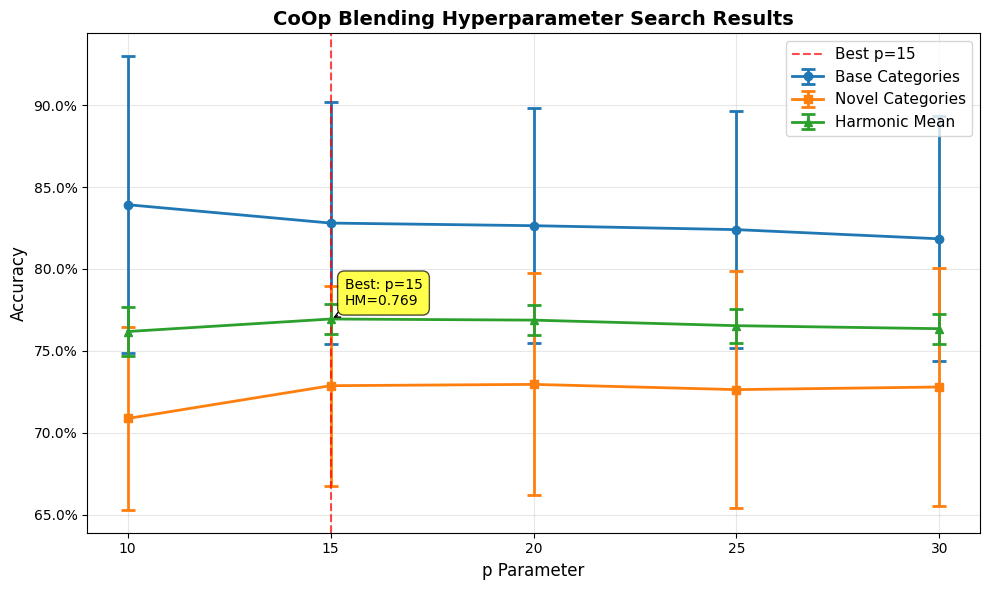

In [31]:
def plot_coop_blending_results(final_param_results, title="CoOp Blending Hyperparameter Search Results", figsize=(10, 6)):
    """
    Plot the mean accuracy results from CoOp blending hyperparameter search.

    Args:
        final_param_results (list): List of dictionaries containing results for each p value
        title (str): Plot title
        save_path (str, optional): Path to save the plot
        figsize (tuple): Figure size (width, height)
    """

    # Extract data from results
    p_values = [result['p'] for result in final_param_results]

    mean_acc_base = [result['mean_acc_base'] for result in final_param_results]
    mean_acc_novel = [result['mean_acc_novel'] for result in final_param_results]
    mean_harmonic = [result['mean_harmonic'] for result in final_param_results]

    std_acc_base = [result['std_acc_base'] for result in final_param_results]
    std_acc_novel = [result['std_acc_novel'] for result in final_param_results]
    std_harmonic = [result['std_harmonic'] for result in final_param_results]

    # Create the plot
    plt.figure(figsize=figsize)

    # Plot the three curves with error bars
    plt.errorbar(p_values, mean_acc_base, yerr=std_acc_base,
                marker='o', linestyle='-', linewidth=2, markersize=6,
                label='Base Categories', capsize=5, capthick=2)

    plt.errorbar(p_values, mean_acc_novel, yerr=std_acc_novel,
                marker='s', linestyle='-', linewidth=2, markersize=6,
                label='Novel Categories', capsize=5, capthick=2)

    plt.errorbar(p_values, mean_harmonic, yerr=std_harmonic,
                marker='^', linestyle='-', linewidth=2, markersize=6,
                label='Harmonic Mean', capsize=5, capthick=2)

    # Customize the plot
    plt.xlabel('p Parameter', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(fontsize=11, loc='best')
    plt.grid(True, alpha=0.3)

    # Set x-axis ticks to show all p values
    plt.xticks(p_values)

    # Format y-axis to show percentages if values are between 0 and 1
    if all(0 <= acc <= 1 for acc in mean_acc_base + mean_acc_novel + mean_harmonic):
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Find and highlight the best p value
    best_result = max(final_param_results, key=lambda x: x['mean_harmonic'])
    best_p = best_result['p']
    best_harmonic = best_result['mean_harmonic']

    # Add vertical line at best p value
    plt.axvline(x=best_p, color='red', linestyle='--', alpha=0.7,
                label=f'Best p={best_p}')
    plt.legend(fontsize=11, loc='best')

    # Add text annotation for best result
    plt.annotate(f'Best: p={best_p}\nHM={best_harmonic:.3f}',
                xy=(best_p, best_harmonic),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    plt.show()

# Run it
plot_coop_blending_results(final_param_results)

## Results Collection

In [32]:
# Set style for better looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Collect all results from our experiments
results_data = {
    'CLIP Zero-shot': {
        'base': zero_shot_base_accuracy * 100,
        'novel': zero_shot_novel_accuracy * 100,
        'harmonic': harmonic_mean(zero_shot_base_accuracy, zero_shot_novel_accuracy) * 100
    },
    'CoOp (Baseline)': {
        'base': coop_base_accuracy * 100,
        'novel': coop_novel_accuracy * 100,
        'harmonic': harmonic_mean(coop_base_accuracy, coop_novel_accuracy) * 100
    },
    'Dynamic CoOp (Ours)': {
        'base': coop_blend_base * 100,
        'novel': coop_blend_novel * 100,
        'harmonic': harmonic_mean(coop_blend_base, coop_blend_novel) * 100
    }
}

print("=== COMPLETE RESULTS SUMMARY ===")
for method, scores in results_data.items():
    print(f"{method}:")
    print(f"\tBase: {scores['base']:.2f}%")
    print(f"\tNovel: {scores['novel']:.2f}%")
    print(f"\tHarmonic: {scores['harmonic']:.2f}%")
    print()

=== COMPLETE RESULTS SUMMARY ===
CLIP Zero-shot:
	Base: 71.33%
	Novel: 78.26%
	Harmonic: 74.64%

CoOp (Baseline):
	Base: 92.68%
	Novel: 14.53%
	Harmonic: 25.12%

Dynamic CoOp (Ours):
	Base: 87.30%
	Novel: 77.72%
	Harmonic: 82.23%



---

# 4. Dynamic CoCoOp

## CoCoOp Foundation: Input‑Conditional Prompt Vectors

CoCoOp builds upon CoOp by replacing static prompt contexts with **instance‑conditional prompt vectors**. Instead of learning fixed context tokens, it introduces a lightweight neural network (**Meta‑Net**) to generate context dynamically:
```
CoOp: [V1][V2][V3][V4] + [CLASS]
CoCoOp: [V1(x)][V2(x)][V3(x)][V4(x)] + [CLASS]
```

This enables per‑image adaptation of textual prompts, improving generalization to unseen classes.

## Integration Strategy: Similarity-Proportional *Conditional* Combination

The integration strategy is identical to the CoOp version, except it uses CoCoOp instead of CoOp

## Expected Benefits

This integrated approach should grant some advantages and trade-offs compared to the CoOp version:

1. **Better Novel Class Generalization**: as CoCoOp has a higher capability of generalization than standard CoOp, even if the cache *fails* to recognize an image belonging to a base class, CoCoOp can still generate effective prompts that preserve discriminative power. This helps maintain high accuracy on novel classes by dynamically adapting the text representation based on the input image, rather than relying solely on learned base-class context.
2. **Base Class Accuracy**: CoCoOp has a lower base class accuracy than CoOp, so the *blended* version might have a lower base class accuracy, possibly lowering also the harmonic mean.

## Model


In [33]:
# Set seed for reproducibility
set_seed(SEED)

class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype

    def forward(self, prompts, tokenized_prompts):
        x = prompts + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        with autocast(DEVICE):
            x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection

        return x


class MetaNet(nn.Module):
    """
    Meta-Net for CoCoOp: generates instance-conditional tokens
    Following the paper's design: Linear with 16x reduction -> ReLU -> Linear
    """
    def __init__(self, vis_dim, ctx_dim):
        super().__init__()
        # Two-layer bottleneck structure with 16x reduction as in the paper
        hid_dim = np.min([vis_dim // 16, 1])

        self.linear1 = nn.Linear(vis_dim, hid_dim)
        self.relu = nn.ReLU(inplace=True)
        self.linear2 = nn.Linear(hid_dim, ctx_dim)

    def forward(self, x):
        with autocast(DEVICE):
            x = self.linear1(x)
            x = self.relu(x)
            x = self.linear2(x)
        return x


class PromptLearner(nn.Module):
    def __init__(self, categories, clip_model: clip.model.CLIP, n_ctx=4):
        super().__init__()
        dtype = clip_model.dtype
        ctx_dim = clip_model.ln_final.weight.shape[0]
        vis_dim = clip_model.visual.output_dim

        # Initialize context vectors
        print(f"Initializing {n_ctx} context vectors")
        ctx_vectors = torch.empty(n_ctx, ctx_dim, dtype=dtype)
        nn.init.normal_(ctx_vectors, std=0.02)
        self.ctx = nn.Parameter(ctx_vectors.to(torch.float32))

        # Initialize Meta-Net
        self.meta_net = MetaNet(vis_dim, ctx_dim)

        # Generate ALL class prompts (not just base classes)
        # This is crucial - we prepare prompts for ALL 102 flower classes
        all_classnames = [CLASS_NAMES[i].replace("_", " ") for i in range(len(CLASS_NAMES))]
        name_lens = [len(_tokenizer.encode(name)) for name in all_classnames]
        prompt_prefix = " ".join(["X"] * n_ctx)
        prompts = [prompt_prefix + " " + name + "." for name in all_classnames]

        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).to(DEVICE)

        # Get embeddings for ALL classes
        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized_prompts).type(dtype).to(DEVICE)

        # These are for ALL classes, not just training classes
        self.register_buffer("token_prefix", embedding[:, :1, :])  # SOS
        self.register_buffer("token_suffix", embedding[:, 1 + n_ctx:, :])  # CLS, EOS

        self.n_cls = len(CLASS_NAMES)  # Total number of classes
        self.n_ctx = n_ctx
        self.tokenized_prompts = tokenized_prompts
        self.name_lens = name_lens
        self.ctx_dim = ctx_dim

    def construct_prompts(self, ctx, prefix, suffix, label=None):
        # dim0 is either batch_size (during training) or n_cls (during testing)
        # ctx: context tokens, with shape of (dim0, n_ctx, ctx_dim)
        # prefix: the sos token, with shape of (n_cls, 1, ctx_dim)
        # suffix: remaining tokens, with shape of (n_cls, *, ctx_dim)

        if label is not None:
            prefix = prefix[label]
            suffix = suffix[label]

        prompts = torch.cat(
            [
                prefix,  # (dim0, 1, dim)
                ctx,     # (dim0, n_ctx, dim)
                suffix,  # (dim0, *, dim)
            ],
            dim=1,
        )

        return prompts

    def forward(self, im_features):
        prefix = self.token_prefix
        suffix = self.token_suffix
        ctx = self.ctx                     # (n_ctx, ctx_dim)
        bias = self.meta_net(im_features)  # (batch, ctx_dim)
        bias = bias.unsqueeze(1)           # (batch, 1, ctx_dim)
        ctx = ctx.unsqueeze(0)             # (1, n_ctx, ctx_dim)
        ctx_shifted = ctx + bias           # (batch, n_ctx, ctx_dim)

        # Use instance-conditioned context tokens for all classes
        prompts = []
        for ctx_shifted_i in ctx_shifted:
            ctx_i = ctx_shifted_i.unsqueeze(0).expand(self.n_cls, -1, -1)
            pts_i = self.construct_prompts(ctx_i, prefix, suffix)  # (n_cls, n_tkn, ctx_dim)
            prompts.append(pts_i)
        prompts = torch.stack(prompts)

        return prompts


class CustomClip(nn.Module):
    """
    CoCoOp implementation
    """
    def __init__(self, categories, clip_model: clip.model.CLIP, context=8):
        super().__init__()
        self.prompt_learner = PromptLearner(categories, clip_model, n_ctx=context)
        self.tokenized_prompts = self.prompt_learner.tokenized_prompts
        self.image_encoder = clip_model.visual
        self.text_encoder = TextEncoder(clip_model)
        self.logit_scale = clip_model.logit_scale
        self.dtype = clip_model.dtype

        # Store categories that were used for training
        self.training_categories = categories

    def forward(self, image, label=None):
        tokenized_prompts = self.tokenized_prompts
        logit_scale = self.logit_scale.exp()

        image_features = self.image_encoder(image.type(self.dtype))
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        prompts = self.prompt_learner(image_features)

        logits = []
        for pts_i, imf_i in zip(prompts, image_features):
            text_features = self.text_encoder(pts_i, tokenized_prompts)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            l_i = logit_scale * imf_i @ text_features.t()
            logits.append(l_i)
        logits = torch.stack(logits)

        if self.prompt_learner.training and label is not None:
            # During training, compute loss only on the training categories
            return F.cross_entropy(logits[:, self.training_categories], label)

        return logits

## CoCoOp Training

In [34]:
def cocoop_training(model: CustomClip, train_set, dev_set, device, base_classes,
                    learning_rate=0.002, num_epochs=10, batch_size=1, grad_clip_norm=1.0,
                    model_path=None, clip_model=None):
    """
    CoCoOp training function optimized for instance-conditional prompts

    Args:
        model: CoCoOp model
        train_set: Training dataset
        dev_set: Development dataset
        device: Device to run on
        base_classes: List of base class indices
        learning_rate: Learning rate
        num_epochs: Number of training epochs
        batch_size: Batch size (paper uses 1 for CoCoOp)
        grad_clip_norm: Gradient clipping norm
        model_path: Path to save the best model
    """
    assert model_path is not None, "Model path must be provided"

    model.to(device)
    model.train()

    # Use smaller batch size for CoCoOp due to memory constraints
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        worker_init_fn=worker_init_fn)

    # Only optimize prompt learner parameters (context vectors and Meta-Net)
    optimizer = optim.AdamW(model.prompt_learner.parameters(), lr=learning_rate, weight_decay=0.01)

    # Label mapping for training classes only
    label_map = {original_label: new_label for new_label, original_label in enumerate(base_classes)}

    # Mixed precision training
    scaler = GradScaler() if str(device) == "cuda" else None
    use_amp = device == "cuda"

    # Early stopping
    best_acc = -float('inf')
    patience = 3
    patience_counter = 0
    best_model_state = None

    print(f"Starting CoCoOp training with batch size {batch_size}, AMP: {use_amp}")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        running_total = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for images, targets in progress_bar:
            images = images.to(device)
            targets = targets.to(device)

            # Map targets to contiguous indices
            mapped_targets = torch.tensor([label_map[t.item()] for t in targets],
                                        dtype=torch.long, device=device)

            optimizer.zero_grad()

            # Forward pass with optional mixed precision
            if use_amp:
                with autocast(device):
                    # Get all logits (for all 102 classes)
                    logits = model(images)
                    # But compute loss only on training classes
                    logits_train = logits[:, base_classes]
                    loss = F.cross_entropy(logits_train, mapped_targets)

                # Backward pass with gradient scaling
                scaler.scale(loss).backward()

                # Gradient clipping with proper unscaling
                if grad_clip_norm is not None:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.prompt_learner.parameters(), max_norm=grad_clip_norm)

                # Update with scaler
                scaler.step(optimizer)
                scaler.update()
            else:
                # Standard training without mixed precision
                logits = model(images)
                # Compute loss only on training classes
                logits_train = logits[:, base_classes]
                loss = F.cross_entropy(logits_train, mapped_targets)

                # Backward pass
                loss.backward()

                # Gradient clipping
                if grad_clip_norm is not None:
                    torch.nn.utils.clip_grad_norm_(model.prompt_learner.parameters(), max_norm=grad_clip_norm)

                # Update
                optimizer.step()

            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(logits_train.detach(), 1)
            running_corrects += (predicted == mapped_targets).sum().item()
            running_total += mapped_targets.size(0)

            # Update progress bar
            current_acc = running_corrects / running_total if running_total > 0 else 0.0
            progress_bar.set_postfix(loss=loss.item(), acc=current_acc)

        # Epoch statistics
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / running_total

        # Validation
        dev_acc = eval_cocoop(model, dev_set, base_classes, batch_size=32, device=device, label="Dev")

        print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Train Acc: {epoch_acc:.4f} - Dev Acc: {dev_acc:.4f}')

        # Early stopping
        if dev_acc > best_acc:
            best_acc = dev_acc
            patience_counter = 0
            best_model_state = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), model_path)
            print(f"New best model saved with dev accuracy: {best_acc:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping after {epoch+1} epochs")
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    print(f"Training completed! Best dev accuracy: {best_acc:.4f}")
    return model


@torch.no_grad()
def eval_cocoop(model, dataset, categories, batch_size, device, label=""):
    """
    Unified evaluation function for CoCoOp that works on ANY set of categories
    The key insight: CoCoOp generates prompts for ALL 102 classes, then we just
    select the relevant logits based on which categories we're evaluating on.

    Args:
        model: Trained CoCoOp model
        dataset: Dataset to evaluate on
        categories: List of category indices to evaluate on (subset of all 102 classes)
        batch_size: Batch size for evaluation
        device: Device to run on
        label: Label for progress bar

    Returns:
        accuracy: Accuracy on the dataset
    """
    model.eval()

    # Map from full class indices to evaluation indices
    # e.g., if categories = [50, 51, ..., 101], then 50 -> 0, 51 -> 1, etc.
    eval_class_to_idx = {cls: idx for idx, cls in enumerate(categories)}

    # Create dataloader
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        worker_init_fn=worker_init_fn)

    correct_predictions = 0
    total_predictions = 0

    for images, targets in tqdm(dataloader, desc=label):
        images = images.to(device)
        targets = targets.to(device)

        # Get logits for ALL 102 classes
        logits = model(images)  # Shape: [batch_size, 102]

        # Select only the logits for the categories we're evaluating on
        selected_logits = logits[:, categories]  # Shape: [batch_size, len(categories)]

        # Map targets to the evaluation index space
        mapped_targets = torch.tensor([eval_class_to_idx[t.item()] for t in targets],
                                    dtype=torch.long, device=device)

        # Get predictions
        _, predicted = torch.max(selected_logits, 1)

        # Update statistics
        correct_predictions += (predicted == mapped_targets).sum().item()
        total_predictions += mapped_targets.size(0)

    accuracy = correct_predictions / total_predictions
    return accuracy

In [35]:
context = 8     # As suggested in the paper
model_path = f"models/cocoop_ctx{context}_unified.pth"

# Initialize CoCoOp model
print("Initializing CoCoOp model...")
cocoop_model = CustomClip(
    categories=base_classes,  # Training categories only
    clip_model=model,
    context=context
)

if not os.path.exists(model_path):
    print(f"\nTraining CoCoOp model...")
    print(f"Model will be saved to: {model_path}")

    cocoop_model = cocoop_training(
        model=cocoop_model,
        train_set=train_base,  # Use few-shot dataset
        dev_set=val_base,
        device=DEVICE,
        base_classes=base_classes,
        learning_rate=0.002,
        num_epochs=10,  # More epochs for few-shot learning
        batch_size=1,   # Batch size 1 as recommended in paper
        grad_clip_norm=1.0,
        model_path=model_path,
        clip_model=model
    )
else:
    print(f"\nLoading pre-trained CoCoOp model from: {model_path}")
    cocoop_model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    cocoop_model.to(DEVICE)

/tmp/ipython-input-34-147989977.py:39: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if str(device) == "cuda" else None


Initializing CoCoOp model...
Initializing 8 context vectors

Training CoCoOp model...
Model will be saved to: models/cocoop_ctx8_unified.pth
Starting CoCoOp training with batch size 1, AMP: True


Dev: 100%|██████████| 16/16 [00:07<00:00,  2.16it/s]


Epoch 1/10 - Loss: 1.7791 - Train Acc: 0.5647 - Dev Acc: 0.7098
New best model saved with dev accuracy: 0.7098


Dev: 100%|██████████| 16/16 [00:07<00:00,  2.14it/s]


Epoch 2/10 - Loss: 1.0351 - Train Acc: 0.7353 - Dev Acc: 0.7608
New best model saved with dev accuracy: 0.7608


Dev: 100%|██████████| 16/16 [00:07<00:00,  2.17it/s]


Epoch 3/10 - Loss: 0.8309 - Train Acc: 0.7686 - Dev Acc: 0.8039
New best model saved with dev accuracy: 0.8039


Dev: 100%|██████████| 16/16 [00:07<00:00,  2.16it/s]


Epoch 4/10 - Loss: 0.6653 - Train Acc: 0.8176 - Dev Acc: 0.8412
New best model saved with dev accuracy: 0.8412


Dev: 100%|██████████| 16/16 [00:07<00:00,  2.15it/s]


Epoch 5/10 - Loss: 0.5419 - Train Acc: 0.8569 - Dev Acc: 0.8725
New best model saved with dev accuracy: 0.8725


Dev: 100%|██████████| 16/16 [00:07<00:00,  2.12it/s]


Epoch 6/10 - Loss: 0.4417 - Train Acc: 0.8961 - Dev Acc: 0.8902
New best model saved with dev accuracy: 0.8902


Dev: 100%|██████████| 16/16 [00:07<00:00,  2.14it/s]


Epoch 7/10 - Loss: 0.3680 - Train Acc: 0.9098 - Dev Acc: 0.8980
New best model saved with dev accuracy: 0.8980


Dev: 100%|██████████| 16/16 [00:07<00:00,  2.14it/s]


Epoch 8/10 - Loss: 0.3014 - Train Acc: 0.9275 - Dev Acc: 0.9255
New best model saved with dev accuracy: 0.9255


Dev: 100%|██████████| 16/16 [00:07<00:00,  2.15it/s]


Epoch 9/10 - Loss: 0.2517 - Train Acc: 0.9333 - Dev Acc: 0.9176


Dev: 100%|██████████| 16/16 [00:07<00:00,  2.15it/s]

Epoch 10/10 - Loss: 0.2128 - Train Acc: 0.9412 - Dev Acc: 0.9235
Training completed! Best dev accuracy: 0.9255


## CoCoOp Evaluation

In [36]:
 # --- EVAL CoCoOp STANDARD (BASE/NOVEL) ---
print("\n🧠 Evaluating CoCoOp...")
cocoop_base_acc = eval_cocoop(
    model=cocoop_model,
    dataset=test_base,
    categories=base_classes,
    batch_size=32,
    device=DEVICE,
    label="CoCoOp (Base)"
)
print("🧠 Evaluating CoOp on Novel Classes...")
cocoop_novel_acc = eval_cocoop(
    model=cocoop_model,
    dataset=test_novel,
    categories=novel_classes,
    batch_size=32,
    device=DEVICE,
    label="CoCoOp (Novel)"
)

print(f"\n🔍 CoCoOp Base classes accuracy: {cocoop_base_acc*100:.2f}%")
print(f"🔍 CoCoOp Novel classes accuracy: {cocoop_novel_acc*100:.2f}%")
print(f"🔍 CoCoOp Harmonic mean: {harmonic_mean(cocoop_base_acc, cocoop_novel_acc)*100:.2f}%")


🧠 Evaluating CoCoOp...


CoCoOp (Base): 100%|██████████| 78/78 [00:34<00:00,  2.26it/s]


🧠 Evaluating CoOp on Novel Classes...


CoCoOp (Novel): 100%|██████████| 115/115 [00:51<00:00,  2.25it/s]


🔍 CoCoOp Base classes accuracy: 90.30%
🔍 CoCoOp Novel classes accuracy: 76.39%
🔍 CoCoOp Harmonic mean: 82.76%


## Dynamic CoCoOp evaluation

In [37]:
@torch.no_grad()
def eval_cocoop_blending_dynamic_alpha(cp_model, clip_model, dataset, categories, batch_size, device, label="", keys=None, p=20):
    cp_model.eval()
    clip_model.eval()
    cat2idx = {cat: i for i, cat in enumerate(categories)}

    # Pre-compute generic CLIP text features (these don't change)
    generic_prompts = [f"a photo of a {CLASS_NAMES[c]}, a type of flower." for c in categories]
    generic_tokens = clip.tokenize(generic_prompts).to(device)
    clip_text_features = clip_model.encode_text(generic_tokens)
    clip_text_features = clip_text_features / clip_text_features.norm(dim=-1, keepdim=True)

    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        worker_init_fn=worker_init_fn)

    correct = 0
    total = 0

    for images, targets in tqdm(dataloader, desc=label):
        images = images.to(device)
        targets = torch.Tensor([cat2idx[t.item()] for t in targets]).long().to(device)

        # Encode images
        image_features = clip_model.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        if keys is None:
            raise ValueError("The 'keys' argument must not be None.")

        # Calculate dynamic alpha
        with autocast(device):
          S = image_features @ keys.T
          S_trans = torch.pow(S, p)
          alpha = S_trans

        # Generate CoOp text features using image features
        cocoop_prompts = cp_model.prompt_learner(image_features)  # Pass image_features here
        cocoop_tokenized_prompts = cp_model.prompt_learner.tokenized_prompts

        # Process each batch item separately since coop_prompts has shape (batch, n_cls, n_tkn, ctx_dim)
        batch_logits = []
        for i in range(images.size(0)):
            # Get prompts for this specific image
            cocoop_text_features_i = cp_model.text_encoder(cocoop_prompts[i], cocoop_tokenized_prompts)
            cocoop_text_features_i = cocoop_text_features_i / cocoop_text_features_i.norm(dim=-1, keepdim=True)

            # Map categories to the full class space if needed
            # Assuming categories contains indices into the full CLASS_NAMES
            category_indices = torch.tensor([cat for cat in categories], device=device)

            # Extract relevant features for the current categories
            cocoop_text_features_subset = cocoop_text_features_i[category_indices]  # (n_categories, dim)

            # Blend features for this image
            alpha_i = alpha[i].unsqueeze(1)  # (n_categories, 1) - should match categories length
            blend_feat_i = alpha_i * cocoop_text_features_subset + (1 - alpha_i) * clip_text_features
            blend_feat_i = blend_feat_i / blend_feat_i.norm(dim=-1, keepdim=True)

            # Calculate logits for this image
            logits_i = image_features[i] @ blend_feat_i.T  # (n_categories,)
            batch_logits.append(logits_i)

        logits = torch.stack(batch_logits)  # (batch, n_classes)
        pred = logits.argmax(dim=1)
        correct += (pred == targets).sum().item()
        total += targets.size(0)

    return correct / total

In [38]:
 # --- EVAL CoCoOp Blending (BASE/NOVEL) ---
print("\n🧠 Evaluating Dynamic CoCoOp...")
cocoop_blend_base = eval_cocoop_blending_dynamic_alpha(
    cp_model=cocoop_model,
    clip_model=model,
    dataset=test_base,
    categories=base_classes,
    batch_size=128,
    device=DEVICE,
    label="Dynamic CoCoOp (Base)",
    keys=keys,
    p=best_p
)
print("🧠 Evaluating Dynamic CoOp on Novel Classes...")
cocoop_blend_novel = eval_cocoop_blending_dynamic_alpha(
    cp_model=cocoop_model,
    clip_model=model,
    dataset=test_novel,
    categories=novel_classes,
    batch_size=128,
    device=DEVICE,
    label="Dynamic CoCoOp (Novel)",
    keys=keys,
    p=best_p
)

print(f"\n🔍 Dynamic CoCoOp Base classes accuracy: {cocoop_blend_base*100:.2f}%")
print(f"🔍 Dynamic CoCoOp Novel classes accuracy: {cocoop_blend_novel*100:.2f}%")
print(f"🔍 Dynamic CoCoOp Harmonic mean: {harmonic_mean(cocoop_blend_base, cocoop_blend_novel)*100:.2f}%")


🧠 Evaluating Dynamic CoCoOp...


Dynamic CoCoOp (Base): 100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


🧠 Evaluating Dynamic CoOp on Novel Classes...


Dynamic CoCoOp (Novel): 100%|██████████| 29/29 [00:51<00:00,  1.79s/it]


🔍 Dynamic CoCoOp Base classes accuracy: 84.35%
🔍 Dynamic CoCoOp Novel classes accuracy: 76.88%
🔍 Dynamic CoCoOp Harmonic mean: 80.44%


In [39]:
results_data['CoCoOp (Baseline)'] = {
    'base': cocoop_base_acc * 100,
    'novel': cocoop_novel_acc * 100,
    'harmonic': harmonic_mean(cocoop_base_acc, cocoop_novel_acc) * 100
}

results_data['Dynamic CoCoOp (Ours)'] = {
    'base': cocoop_blend_base * 100,
    'novel': cocoop_blend_novel * 100,
    'harmonic': harmonic_mean(cocoop_blend_base, cocoop_blend_novel) * 100
}

print("=== COMPLETE RESULTS SUMMARY ===")
for method, scores in results_data.items():
    print(f"{method}:")
    print(f"\tBase: {scores['base']:.2f}%")
    print(f"\tNovel: {scores['novel']:.2f}%")
    print(f"\tHarmonic: {scores['harmonic']:.2f}%")
    print()

=== COMPLETE RESULTS SUMMARY ===
CLIP Zero-shot:
	Base: 71.33%
	Novel: 78.26%
	Harmonic: 74.64%

CoOp (Baseline):
	Base: 92.68%
	Novel: 14.53%
	Harmonic: 25.12%

Dynamic CoOp (Ours):
	Base: 87.30%
	Novel: 77.72%
	Harmonic: 82.23%

CoCoOp (Baseline):
	Base: 90.30%
	Novel: 76.39%
	Harmonic: 82.76%

Dynamic CoCoOp (Ours):
	Base: 84.35%
	Novel: 76.88%
	Harmonic: 80.44%



## Results

In [40]:
########## <--- TABLE OUTPUT ---> ##########

base_acc_table = [zero_shot_base_accuracy, tip_final_base_acc, tip_blend_base_accuracy, tip_f_blend_base_accuracy, coop_base_accuracy, cocoop_base_acc, coop_blend_base, cocoop_blend_base]
novel_acc_table = [zero_shot_novel_accuracy, tip_final_novel_acc, tip_blend_novel_accuracy, tip_f_blend_novel_accuracy, coop_novel_accuracy, cocoop_novel_acc, coop_blend_novel, cocoop_blend_novel]
h_mean_table = [harmonic_mean(b, n) for b, n in zip(base_acc_table, novel_acc_table)]

method_names = ['Zero-shot CLIP', 'Tip-adapter', 'Tip-adapter (ours)', 'Tip-adapter-F (ours)', 'CoOp', 'CoCoOp', 'Dynamic CoOp (ours)', 'Dynamic CoCoOp (ours)']

data = {
    "Method": method_names,
    "Base (%)": base_acc_table,
    "Novel (%)": novel_acc_table,
    "H-mean (%)": h_mean_table
}

# Create DataFrame
df = pd.DataFrame(data)

# Helper function to convert to formatted string with bold max
def format_column(col):
    col_pct = [v * 100 for v in col]
    max_val = max(col_pct)
    return [f"**{v:.2f}**" if v == max_val else f"{v:.2f}" for v in col_pct]

# Format each column
formatted_base = format_column(base_acc_table)
formatted_novel = format_column(novel_acc_table)
formatted_hmean = format_column(h_mean_table)

# Create the final DataFrame
df = pd.DataFrame({
    "**Method**": method_names,
    "**Base (%)**": formatted_base,
    "**Novel (%)**": formatted_novel,
    "**H-mean (%)**": formatted_hmean,
})

# Bold headers manually (Markdown doesn't do this automatically)
df.columns = [f"**{col}**" for col in df.columns]

# Convert into Markdown e view on notebook
markdown_table = df.to_markdown(index=False)
display(Markdown(markdown_table))


| ****Method****        | ****Base (%)****   | ****Novel (%)****   | ****H-mean (%)****   |
|:----------------------|:-------------------|:--------------------|:---------------------|
| Zero-shot CLIP        | 71.33              | **78.26**           | 74.64                |
| Tip-adapter           | 90.86              | 2.18                | 4.25                 |
| Tip-adapter (ours)    | 83.74              | 78.24               | 80.90                |
| Tip-adapter-F (ours)  | 91.67              | 74.89               | 82.44                |
| CoOp                  | **92.68**          | 14.53               | 25.12                |
| CoCoOp                | 90.30              | 76.39               | **82.76**            |
| Dynamic CoOp (ours)   | 87.30              | 77.72               | 82.23                |
| Dynamic CoCoOp (ours) | 84.35              | 76.88               | 80.44                |

The Dynamic CoCoOp version presents, as discussed before, a lower base accuracy and harmonic mean, and in contrast to what we thought, the Dynamic CoCoOp doesn't closes the gap of the novel accuracy with the Zero-shot CLIP. It is similar to the Dynamic CoOp in novel accuracy, losing only about 0.46 percentage points, suggesting that the cache mechanism plays a key role in achieving consistent recognition.

As shown by the table, The **Dynamic CoOp** method is the best for the harmonic mean, while only losing about 0.16 percentage points on novel classes.

## Context length
The Dynamic CoCoOp approach was tested on different context length. The [CoCoOp paper](https://arxiv.org/pdf/2203.05557) suggested that context length equal to 8 yielded the best results. We wanted to verify that this is also the case for out approach. The following table summarizes the results. The best context size is the same as the paper.

| Context length       | Base (%) | Novel (%) | H‑mean (%) |
|----------------------|---------:|----------:|-----------:|
| 4                    |    82.77 | **77.88** |      80.33 |
| 8                    |**85.77** |     77.64 |   **81.50**|
| 16                   |    81.44 |     77.64 |      79.54 |

## Multi-Panel Visualization Suite
The following visualization creates a comprehensive analysis that examines our method from multiple perspectives:

- Bar Chart: Direct performance comparison across all metrics
- Scatter Plot: Base vs Novel trade-off visualization
- Improvement Analysis: Gains relative to CLIP zero-shot baseline
- Harmonic Mean Focus: Overall performance ranking

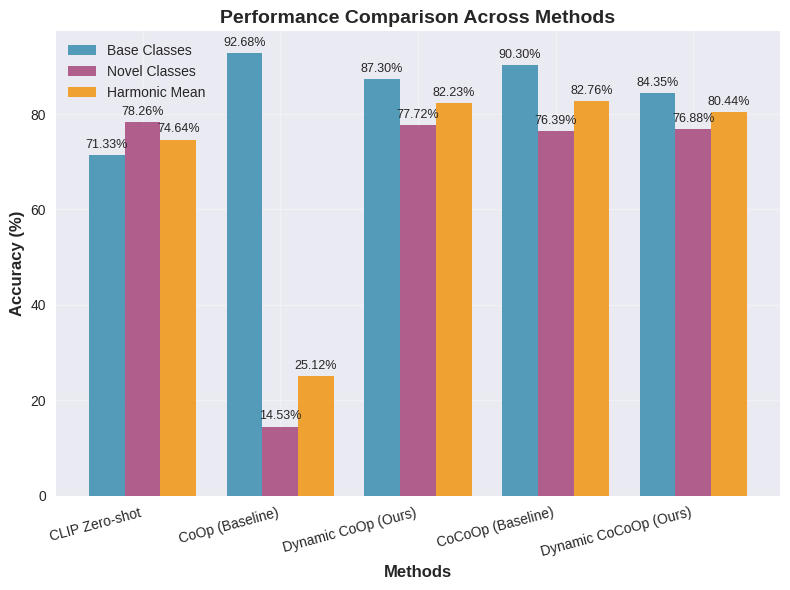

In [41]:
# Create comprehensive visualization suite
fig, ax1 = plt.subplots(figsize=(8, 6))

# 1. Bar Chart Comparison
methods = list(results_data.keys())

base_scores = [results_data[m]['base'] for m in methods]
novel_scores = [results_data[m]['novel'] for m in methods]
harmonic_scores = [results_data[m]['harmonic'] for m in methods]

x = np.arange(len(methods))
width = 0.26

bars1 = ax1.bar(x - width, base_scores, width, label='Base Classes', alpha=0.8, color='#2E86AB')
bars2 = ax1.bar(x, novel_scores, width, label='Novel Classes', alpha=0.8, color='#A23B72')
bars3 = ax1.bar(x + width, harmonic_scores, width, label='Harmonic Mean', alpha=0.8, color='#F18F01')

ax1.set_xlabel('Methods', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Performance Comparison Across Methods', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(methods, rotation=15, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

plt.tight_layout()
plt.show()

### Scatter Plot
The scatter plot reveals the critical base vs novel trade-off that is central to few-shot learning:

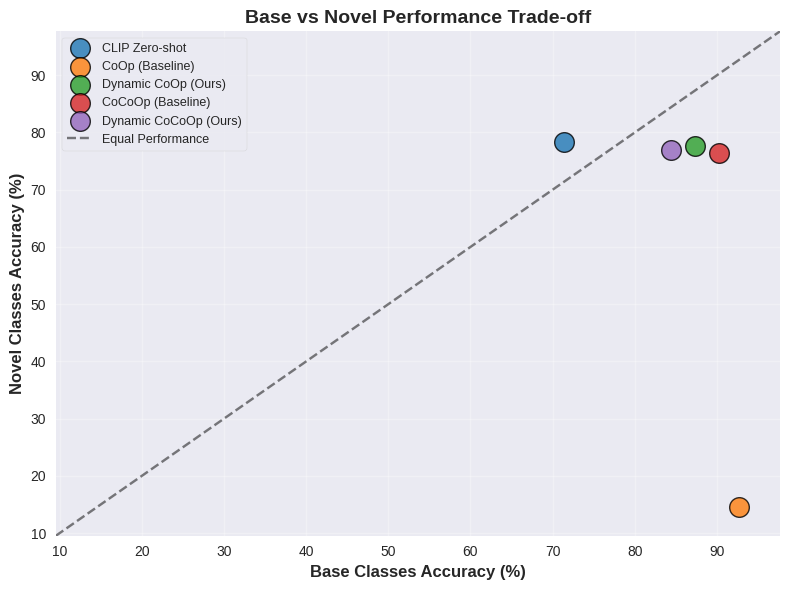

In [42]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

# 2. Base vs Novel Scatter Plot - Trade-off Analysis
fig, ax3 = plt.subplots(figsize=(8, 6))  # Increase figure size

for i, method in enumerate(methods):
    x = results_data[method]['base']
    y = results_data[method]['novel']
    ax3.scatter(x, y, s=200, alpha=0.8, color=colors[i], edgecolors='black', linewidth=1, label=method)

# Equal performance diagonal
min_val = min(min(base_scores), min(novel_scores)) - 5
max_val = max(max(base_scores), max(novel_scores)) + 5
ax3.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Equal Performance')

# Set labels and title
ax3.set_xlabel('Base Classes Accuracy (%)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Novel Classes Accuracy (%)', fontsize=12, fontweight='bold')
ax3.set_title('Base vs Novel Performance Trade-off', fontsize=14, fontweight='bold')

# Adjust legend
ax3.legend(loc='upper left', fontsize=9, frameon=True)

# Grid and limits
ax3.grid(True, alpha=0.3)
ax3.set_xlim(min_val, max_val)
ax3.set_ylim(min_val, max_val)

plt.tight_layout()
plt.show()

This improvement analysis shows how much each method gains over the CLIP zero-shot baseline:

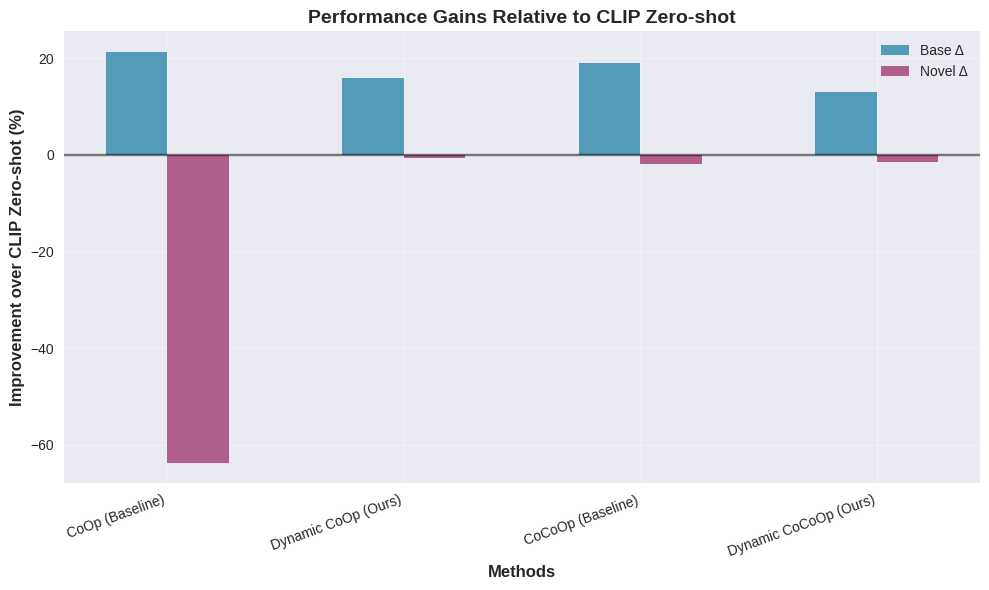

In [43]:
# 3. Improvement Analysis - Gains over Baseline
fig, ax4 = plt.subplots(figsize=(10, 6))

# Calculate improvements relative to CLIP zero-shot
clip_base = results_data['CLIP Zero-shot']['base']
clip_novel = results_data['CLIP Zero-shot']['novel']
clip_harmonic = results_data['CLIP Zero-shot']['harmonic']

improvements = {}
for method in methods[1:]:  # Skip CLIP zero-shot
    improvements[method] = {
        'base': results_data[method]['base'] - clip_base,
        'novel': results_data[method]['novel'] - clip_novel,
        'harmonic': results_data[method]['harmonic'] - clip_harmonic
    }

methods_subset = list(improvements.keys())
base_imp = [improvements[m]['base'] for m in methods_subset]
novel_imp = [improvements[m]['novel'] for m in methods_subset]

x = np.arange(len(methods_subset))
ax4.bar(x - width/2, base_imp, width, label='Base Δ', alpha=0.8, color='#2E86AB')
ax4.bar(x + width/2, novel_imp, width, label='Novel Δ', alpha=0.8, color='#A23B72')

ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax4.set_xlabel('Methods', fontsize=12, fontweight='bold')
ax4.set_ylabel('Improvement over CLIP Zero-shot (%)', fontsize=12, fontweight='bold')
ax4.set_title('Performance Gains Relative to CLIP Zero-shot', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(methods_subset, rotation=20, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The harmonic mean is the most important single metric as it balances both base and novel performance:

/tmp/ipython-input-44-2503646926.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax5.set_xticklabels(methods, rotation=15, ha='right')


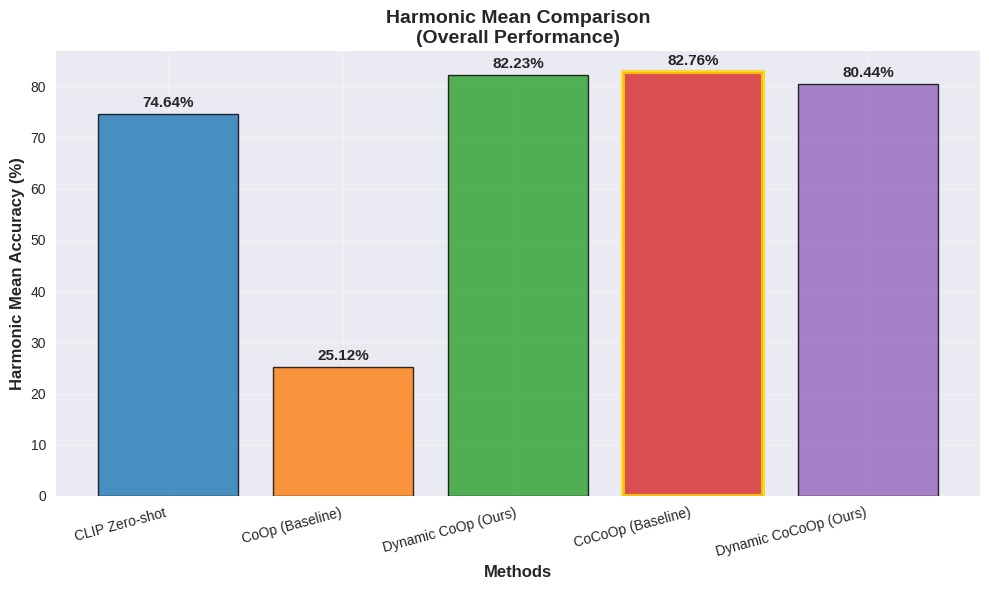

In [44]:
# 4. Harmonic Mean Focus - Overall Performance Ranking
fig, ax5 = plt.subplots(figsize=(10, 6))

harmonic_values = [results_data[m]['harmonic'] for m in methods]

bars = ax5.bar(methods, harmonic_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax5.set_xlabel('Methods', fontsize=12, fontweight='bold')
ax5.set_ylabel('Harmonic Mean Accuracy (%)', fontsize=12, fontweight='bold')
ax5.set_title('Harmonic Mean Comparison\n(Overall Performance)', fontsize=14, fontweight='bold')
ax5.set_xticklabels(methods, rotation=15, ha='right')

# Highlight the best performance
best_idx = np.argmax(harmonic_values)
bars[best_idx].set_edgecolor('gold')
bars[best_idx].set_linewidth(3)

for bar in bars:
    height = bar.get_height()
    ax5.annotate(f'{height:.2f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11, fontweight='bold')

ax5.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Detailed Numerical Analysis
Let's create a comprehensive table and calculate specific improvements to better understand the quantitative differences between methods.

In [45]:
# Create detailed comparison table
df_results = pd.DataFrame(results_data).T
df_results = df_results.round(2)

print("=== DETAILED RESULTS TABLE ===")
print(df_results.to_string())

# Calculate improvements
print("\n=== IMPROVEMENTS OVER CLIP ZERO-SHOT ===")
for method in methods[1:]:
    print(f"\n{method}:")
    base_imp = df_results.loc[method, 'base'] - df_results.loc['CLIP Zero-shot', 'base']
    novel_imp = df_results.loc[method, 'novel'] - df_results.loc['CLIP Zero-shot', 'novel']
    harmonic_imp = df_results.loc[method, 'harmonic'] - df_results.loc['CLIP Zero-shot', 'harmonic']

    print(f"\tBase improvement: {base_imp:+.2f}%")
    print(f"\tNovel improvement: {novel_imp:+.2f}%")
    print(f"\tHarmonic improvement: {harmonic_imp:+.2f}%")

=== DETAILED RESULTS TABLE ===
                        base  novel  harmonic
CLIP Zero-shot         71.33  78.26     74.64
CoOp (Baseline)        92.68  14.53     25.12
Dynamic CoOp (Ours)    87.30  77.72     82.23
CoCoOp (Baseline)      90.30  76.39     82.76
Dynamic CoCoOp (Ours)  84.35  76.88     80.44

=== IMPROVEMENTS OVER CLIP ZERO-SHOT ===

CoOp (Baseline):
	Base improvement: +21.35%
	Novel improvement: -63.73%
	Harmonic improvement: -49.52%

Dynamic CoOp (Ours):
	Base improvement: +15.97%
	Novel improvement: -0.54%
	Harmonic improvement: +7.59%

CoCoOp (Baseline):
	Base improvement: +18.97%
	Novel improvement: -1.87%
	Harmonic improvement: +8.12%

Dynamic CoCoOp (Ours):
	Base improvement: +13.02%
	Novel improvement: -1.38%
	Harmonic improvement: +5.80%



---

# 5. Conclusions

These improved *few-shot adaptation techniques* address a fundamental challenge in transfer learning: balancing adaptation to specific tasks while preserving generalization capabilities. Through the innovative prototype-cache approach with similarity-based weighting, we achieve significant improvements in harmonic mean performance (74.61% → 82.68%) while maintaining CLIP's performance on novel classes.

The proposed approach can be integrated with various *few-shot* learning methods thanks to its **blending** with CLIP, making it more likely that if a sample has not been seen in the training seen, it back-offs to standard CLIP's output for classification.

The cache's robust behaviour suggests that it could be integrated well with methods that overfit a lot on base classes, potentially bringing up the harmonic mean while retaining strong performance on novel classes.

---

# 6. Other work - APoLLo
We also tried to implement [this paper](https://arxiv.org/pdf/2312.01564) because the authors states that it shows a high accuracy both on base and novel classes.

We tried firstly to implement the core of this model, a transformer-like architecture, with self-attention and cross-attention layers.

The adapter was added on top of a frozen CLIP and trained with CLIP's contrastive loss.

In the following cell you will find the adapter architecture:

In [46]:
class ApolloAdapter(nn.Module):
    def __init__(self, hid_size: int, num_heads: int = 8, attn_dropout: float = 0.1, dropout: float = 0.1):
        super().__init__()

        # -- Image components --
        # Self attention
        self.img_self_attn = nn.MultiheadAttention(embed_dim=hid_size, num_heads=num_heads, batch_first=True, dropout=attn_dropout)

        # Cross attention (image queries attend to text)
        self.img_cross_attn = nn.MultiheadAttention(embed_dim=hid_size, num_heads=num_heads, batch_first=True, dropout=attn_dropout)

        # Dropout layer
        self.img_dropout = nn.Dropout(dropout)
        self.img_dropout2 = nn.Dropout(dropout)

        # Feed Forward
        self.img_ff = nn.Sequential(
            nn.Linear(hid_size, hid_size * 2),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hid_size * 2, hid_size)
        )

        # -- Text components -- (symmetric to image)
        self.text_self_attn = nn.MultiheadAttention(embed_dim=hid_size, num_heads=num_heads, batch_first=True, dropout=attn_dropout)

        # Cross attention (text queries attend to image)
        self.text_cross_attn = nn.MultiheadAttention(embed_dim=hid_size, num_heads=num_heads, batch_first=True, dropout=attn_dropout)

        self.text_dropout = nn.Dropout(dropout)
        self.text_dropout2 = nn.Dropout(dropout)

        self.text_ff = nn.Sequential(
            nn.Linear(hid_size, hid_size * 2),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hid_size * 2, hid_size)
        )

    def forward(self, img: torch.Tensor, text: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            img: Image embeddings of shape (batch_size, seq_len, hid_size) or (batch_size, hid_size)
            text: Text embeddings of shape (batch_size, seq_len, hid_size) or (batch_size, hid_size)

        Returns:
            Tuple of (adapted_img, adapted_text)
        """
        # Ensure inputs are 3D
        if img.dim() == 2:
            img = img.unsqueeze(1)  # (batch_size, 1, hid_size)
        if text.dim() == 2:
            text = text.unsqueeze(1)  # (batch_size, 1, hid_size)

        # Ensure inputs are float32 for stability
        original_dtype = img.dtype
        img = img.float()
        text = text.float()

        # Self attention for image
        img_attn, _ = self.img_self_attn(img, img, img)
        img_attn = self.img_dropout(img_attn)
        img = img + img_attn  # Residual connection

        # Self attention for text
        text_attn, _ = self.text_self_attn(text, text, text)
        text_attn = self.text_dropout(text_attn)
        text = text + text_attn  # Residual connection

        # Cross attention

        # Image attends to text
        img_cross_attn, _ = self.img_cross_attn(img, text, text)
        img_cross_attn = self.img_dropout2(img_cross_attn)
        img = img + img_cross_attn  # Residual connection

        # Text attends to image
        text_cross_attn, _ = self.text_cross_attn(text, img, img)
        text_cross_attn = self.text_dropout2(text_cross_attn)
        text = text + text_cross_attn  # Residual connection

        # Feed Forward
        img_ff = self.img_ff(img)
        img = img + img_ff  # Residual connection

        text_ff = self.text_ff(text)
        text = text + text_ff  # Residual connection

        # Convert back to original dtype if needed
        img = img.to(original_dtype)
        text = text.to(original_dtype)

        # If input was 2D, squeeze back
        if img.size(1) == 1:
            img = img.squeeze(1)
        if text.size(1) == 1:
            text = text.squeeze(1)

        return img, text


This adapter brought some improvement for the harmonic mean but overfitted the base classes, so it was discarded as CoCoOp performs better.
The following table sums up the various tentatives and regularization techniques tried to overcome this overfitting (methods in bold are the one that are kept for following experiments, non-bold ones are discarded).

| Method                                   | Base (%) | Novel (%) | H‑mean (%) |
| ---------------------------------------- | -------: | --------: | ---------: |
| **Dropout after xattn + residual**       |    82.33 |     71.33 |      76.44 |
| Dropout = 0.1 with FF                    |    82.05 |     72.17 |      76.79 |
| Dropout = 0.1 with projection layer      |    79.66 | **74.44** |      76.96 |
| **FF with Swish instead of ReLU**        |    82.85 |     72.58 |      77.38 |
| Layer normalization                      |**87.10** |     24.16 |      37.83 |
| Temperature clamping                     |    80.43 |     72.17 |      76.08 |
| Noise injection                          |    85.97 |     69.67 |      76.97 |
| Random prompts (between 5 possibilities) |    80.95 |     69.64 |      74.87 |
| Added distillation loss (23% contribute) |    85.85 |     70.24 |      77.26 |
| **Added distillation loss (41% contribute)** |    86.94 |     70.73 |      78.00 |
| Added distillation loss (50% contribute) |    85.28 |     69.86 |      76.80 |
| Added focal loss                         |    80.55 |     72.82 |      76.49 |
| Focal loss only                          |    78.45 |     70.21 |      74.10 |
| Stochastic dropout                       |    84.55 |     68.82 |      75.88 |
| **More dropout layers**                  |    85.97 |     71.84 |  **78.27** |

The APoLLo model overfits the base classes no matter what and the paper states that image and text augmentation didn't bring big improvements, so this model was discarded for further testing.


## Other work - Image augmentation
Image augmentation was tried on the train dataset, without changing the image colours, as they can be a distinctive trait of a class.
The problem of this approach is that the *cache* learns wrong prototypes of the base classes, leading to lower accuracy of the Tip adapter and consequently of our blended implementations.

---
# 7. References
1. Zhang, R., Fang, R., Zhang, W., Gao, P., Li, K., Dai, J., Qiao, Y., & Li, H. (2021). *Tip‑Adapter: Training‑free CLIP‑Adapter for Better Vision‑Language Modeling*.  
   *arXiv:2111.03930*. Available at: [https://arxiv.org/pdf/2111.03930](https://arxiv.org/pdf/2111.03930)
2. Wang, P., Chen, Q., et al. (2022). *Unified Vision and Language Prompt Learning*.    
 arXiv:2210.07225. Available at: https://arxiv.org/pdf/2210.07225
3. Zhou, K. et al. (2022) *Learning to prompt for vision-language models* - International Journal of Computer Vision, SpringerLink. Available at: https://link.springer.com/article/10.1007/s11263-022-01653-1 .
4. Zhou, K., Yang, J., Loy, C. C., & Liu, Z. (2022). *Conditional Prompt Learning for Vision‑Language Models*.  
   *arXiv:2203.05557*. Available at: [https://arxiv.org/pdf/2203.05557](https://arxiv.org/pdf/2203.05557)
5. Chowdhury, S., Nag, S., & Manocha, D. (2023). *APoLLo: Unified Adapter and Prompt Learning for Vision‑Language Models*.  
   *arXiv:2312.01564*. Available at: [https://arxiv.org/pdf/2312.01564](https://arxiv.org/pdf/2312.01564)
